In [1]:
import numpy as np
import pandas as pd
import joblib

from time import time

from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import matplotlib.pyplot as plt


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

#setting plot styles
plt.style.use('ggplot')
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['forestgreen', 'tomato', 'cornflowerblue'])
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

## Text Exploration

I will be using the review text to predict helpful vs not helpful reviews.

What words occur most frequently in the text?

In [2]:
df = joblib.load('data/clean_dlc_reviews.joblib')

In [3]:
X = df.review

In [4]:
def get_freq_words(sparse_counts, columns):

    # X_cvec is a sparse matrix, so sum() returns a 'matrix' datatype ...
    #   which we then convert into a 1-D ndarray for sorting

    word_counts = np.ravel(sparse_counts.sum(axis=0))
    freq_words = pd.Series(
        word_counts, index=columns).sort_values(ascending=False)

    return freq_words

def hist_counts(series, bins=np.logspace(0, 4, 20), density=True):

    fig, ax = plt.subplots(figsize=(8, 4))
    series.hist(bins=bins, ax=ax, density=density)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title('Word count distribution')

    return fig, ax

97444
the     190741
to       99564
and      96786
it       72331
of       72048
is       69844
you      59220
this     54128
in       47724
for      46222
that     38531
game     36223
with     32225
but      30227
are      29153
on       28272
The      25977
not      24838
have     24573
DLC      24557
dtype: int64


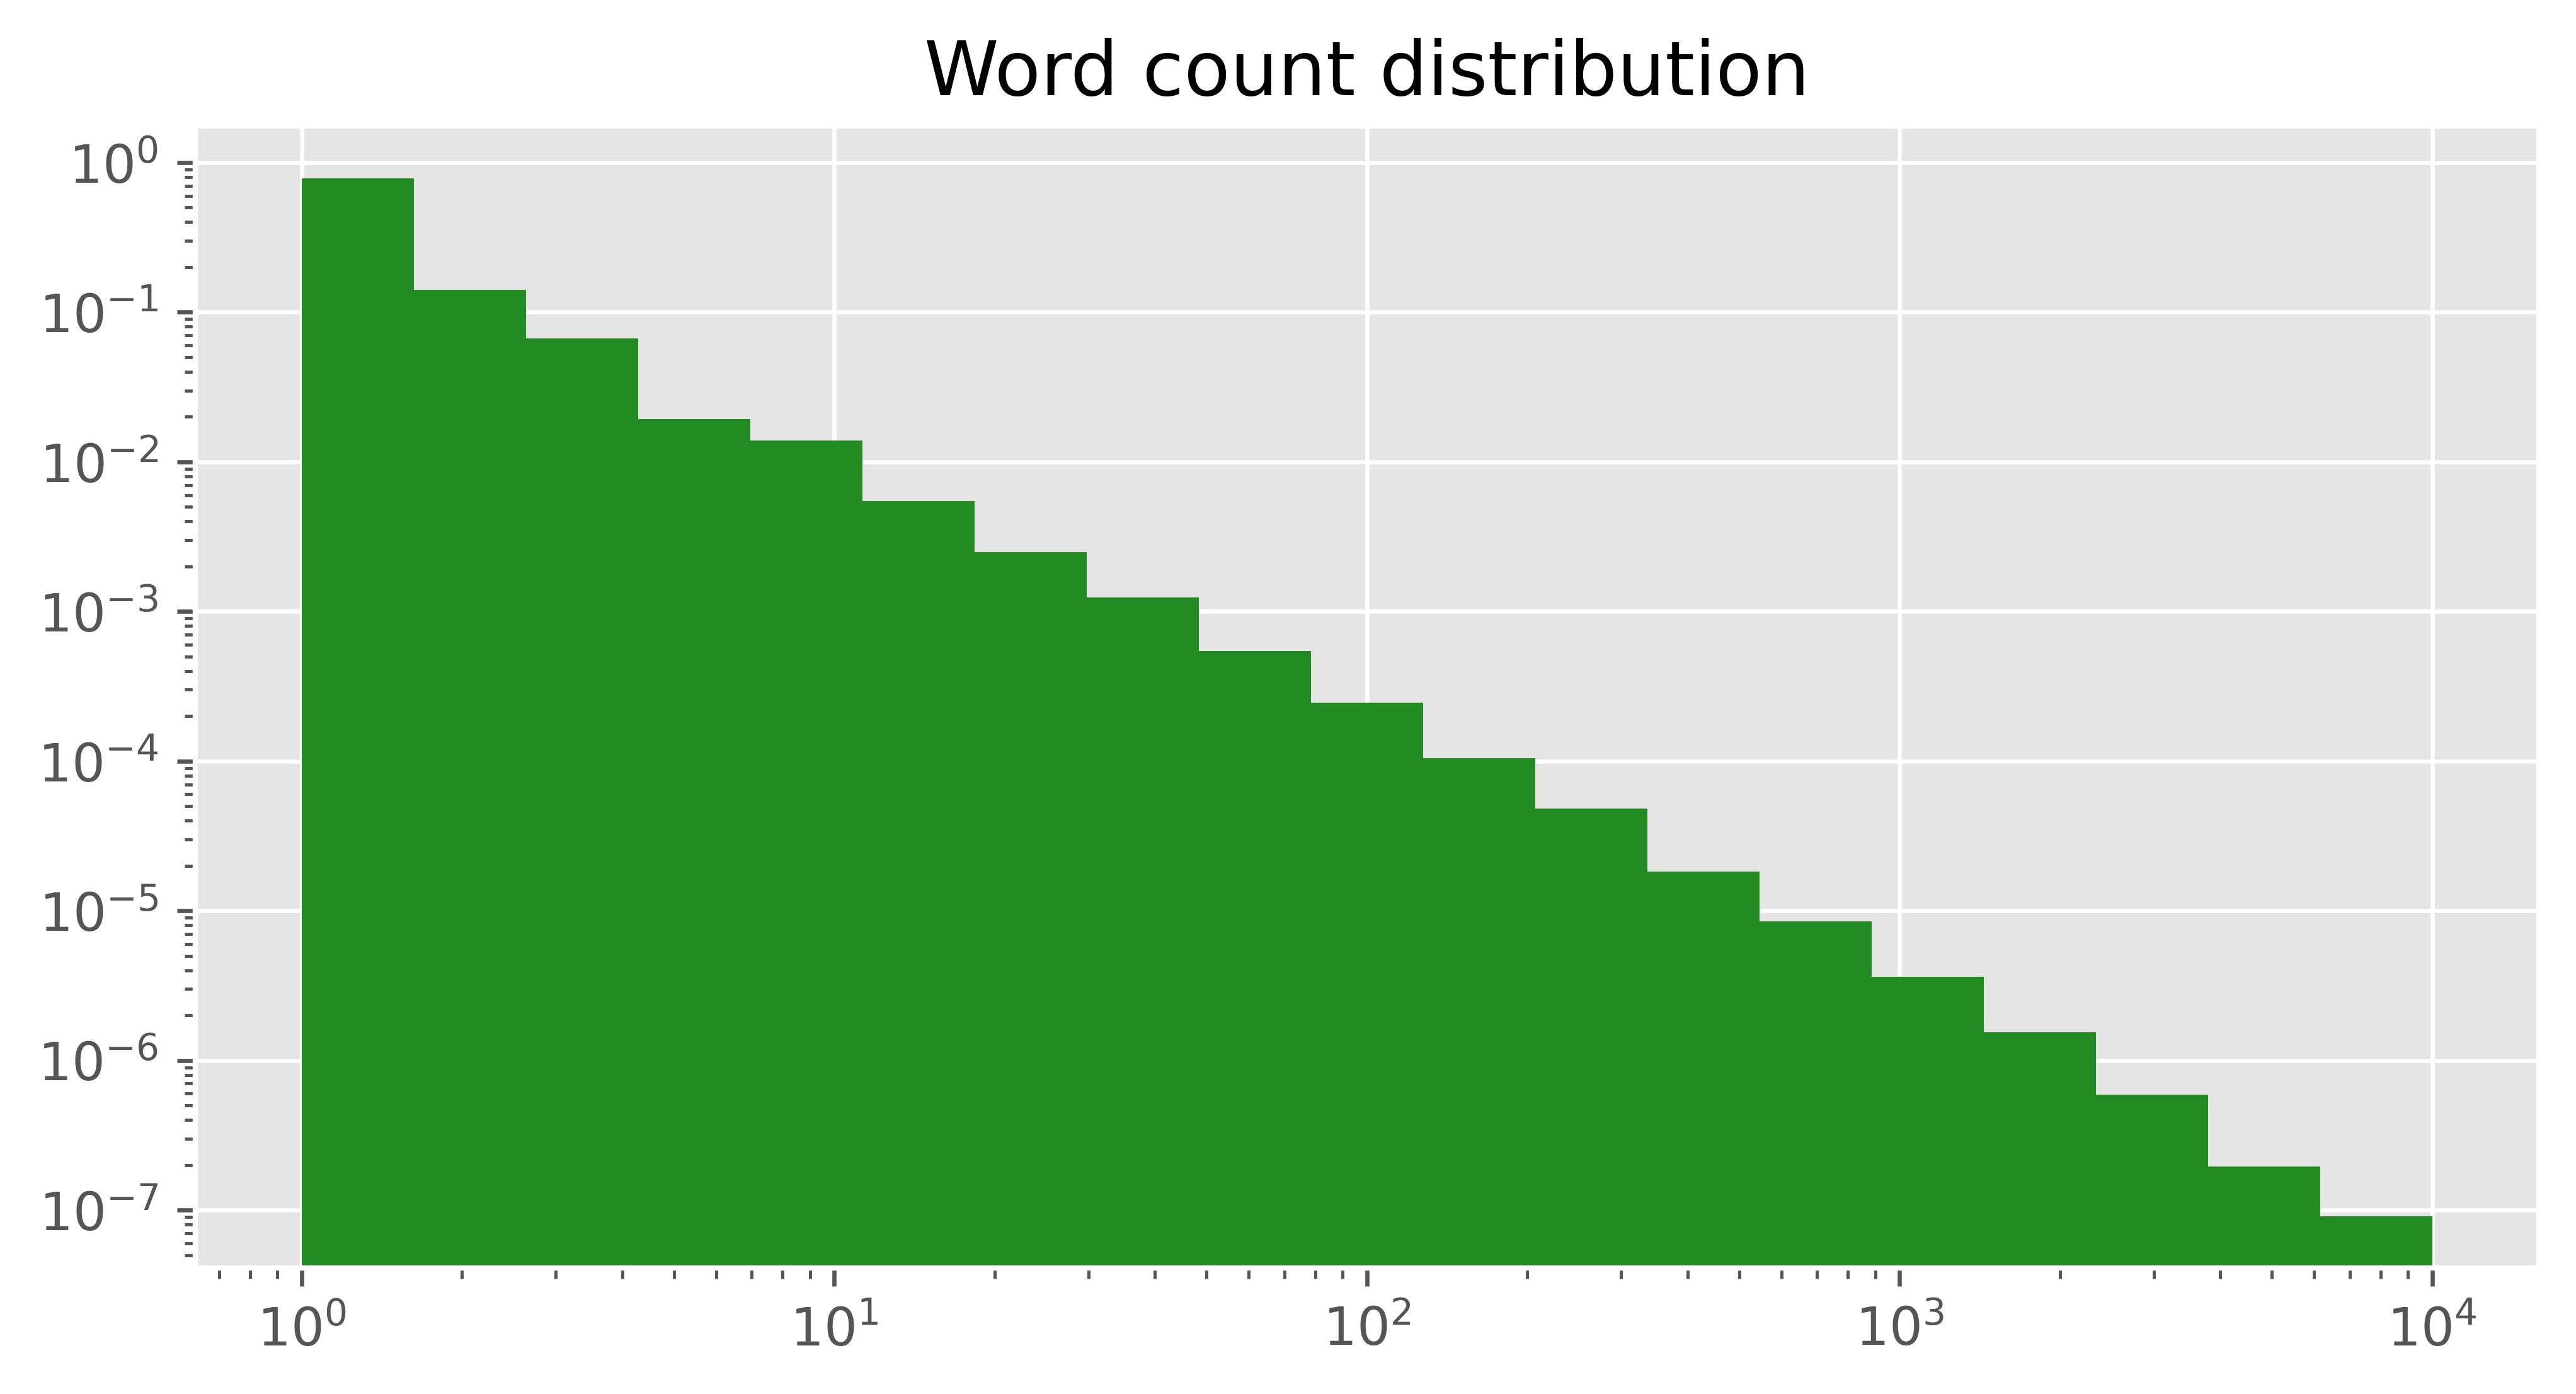

In [5]:
cvec = CountVectorizer(lowercase=False, ngram_range=(1, 1)) 
X_cvec = cvec.fit_transform(X)
columns = cvec.get_feature_names()
freq_words = get_freq_words(X_cvec, columns)
print(len(columns)) #number of words
print(freq_words[:20])
fig, ax = hist_counts(freq_words)

97444
the     5439.297526
to      3278.882389
it      3177.274610
and     3106.204140
is      2691.702769
of      2490.888035
this    2402.773945
you     2308.684594
game    2168.732598
for     2054.188884
in      1872.602194
DLC     1560.062336
that    1514.655616
but     1484.767815
good    1459.282321
not     1410.147029
with    1397.283802
on      1340.596557
are     1286.561692
have    1206.648582
dtype: float64


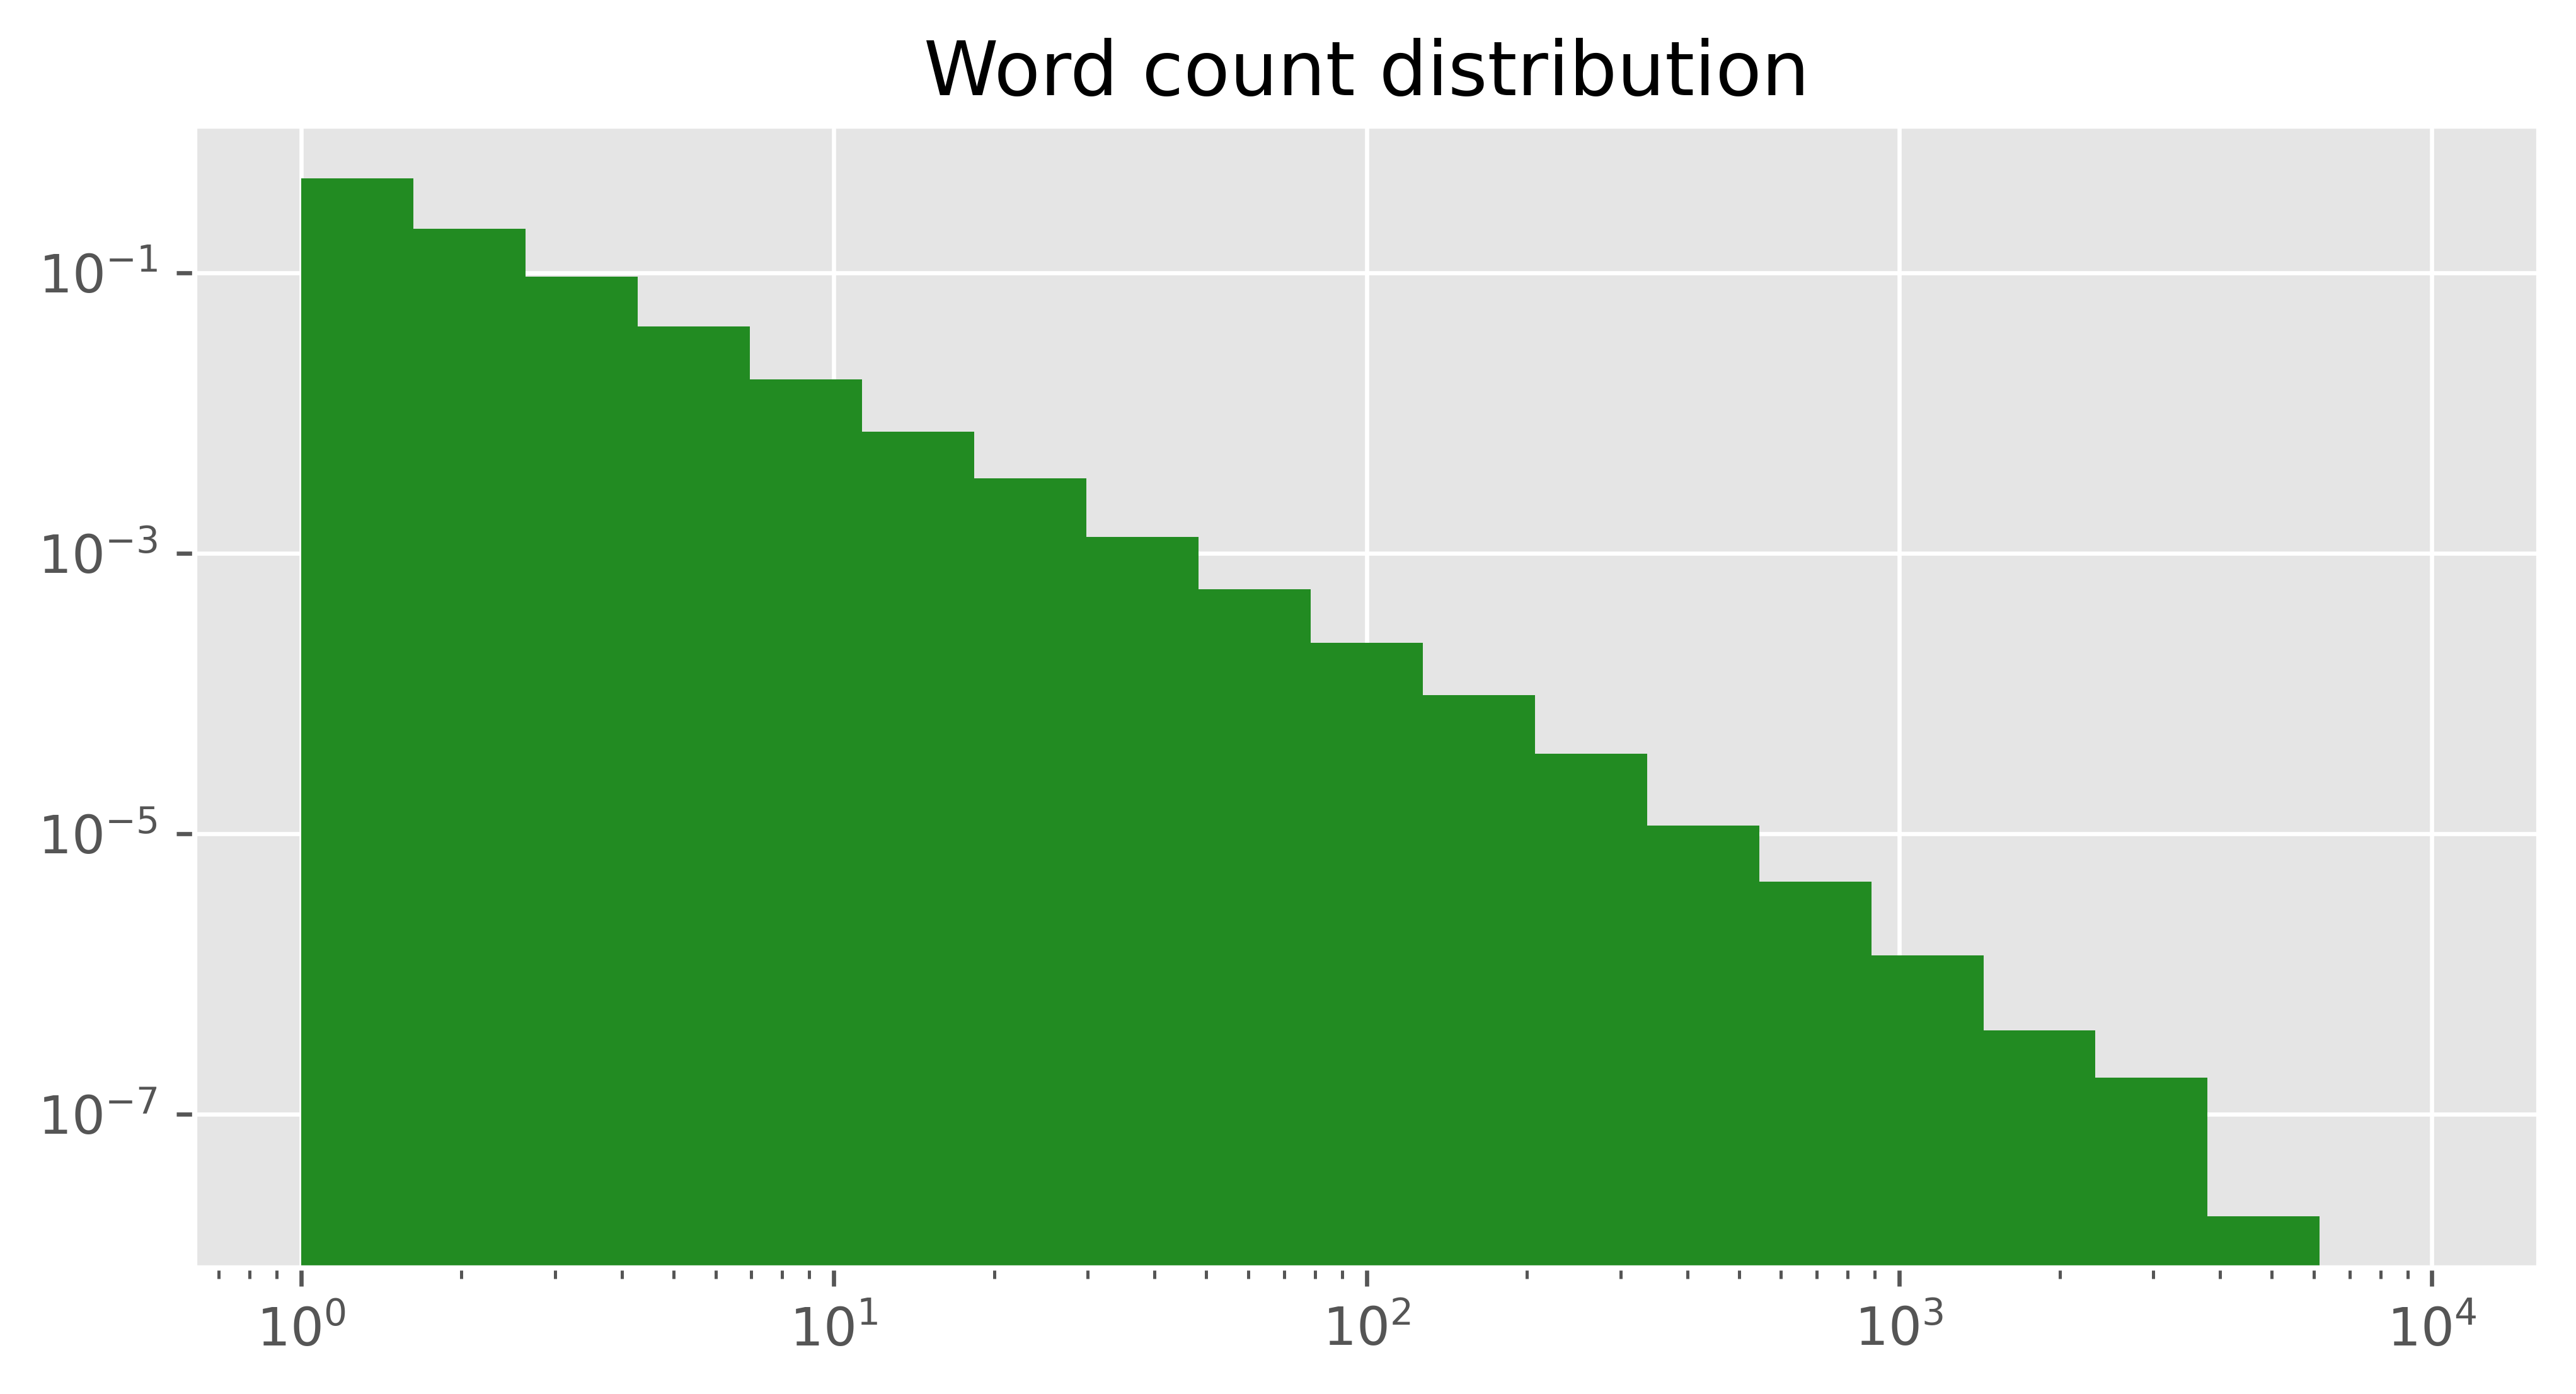

In [6]:
tfvec = TfidfVectorizer(lowercase=False, ngram_range=(1, 1)) 
X_tfvec = tfvec.fit_transform(X)
columns = tfvec.get_feature_names()
freq_words = get_freq_words(X_tfvec, columns)
print(len(columns))
print(freq_words[:20])
fig, ax = hist_counts(freq_words)

### With stop-word removal

In [7]:
cvec = CountVectorizer(stop_words = 'english', lowercase=False, ngram_range=(1, 1)) 
X_cvec = cvec.fit_transform(X)
columns = cvec.get_feature_names()
freq_words = get_freq_words(X_cvec, columns)
print(len(columns))
freq_words[:20]


97139


game      36223
The       25977
DLC       24557
like      18880
just      15272
It        15114
good      14096
td        13031
new       12471
This      12352
really    11938
great      8746
10         8312
worth      8157
play       7602
don        7450
buy        7326
time       7175
pack       7053
fun        6980
dtype: int64

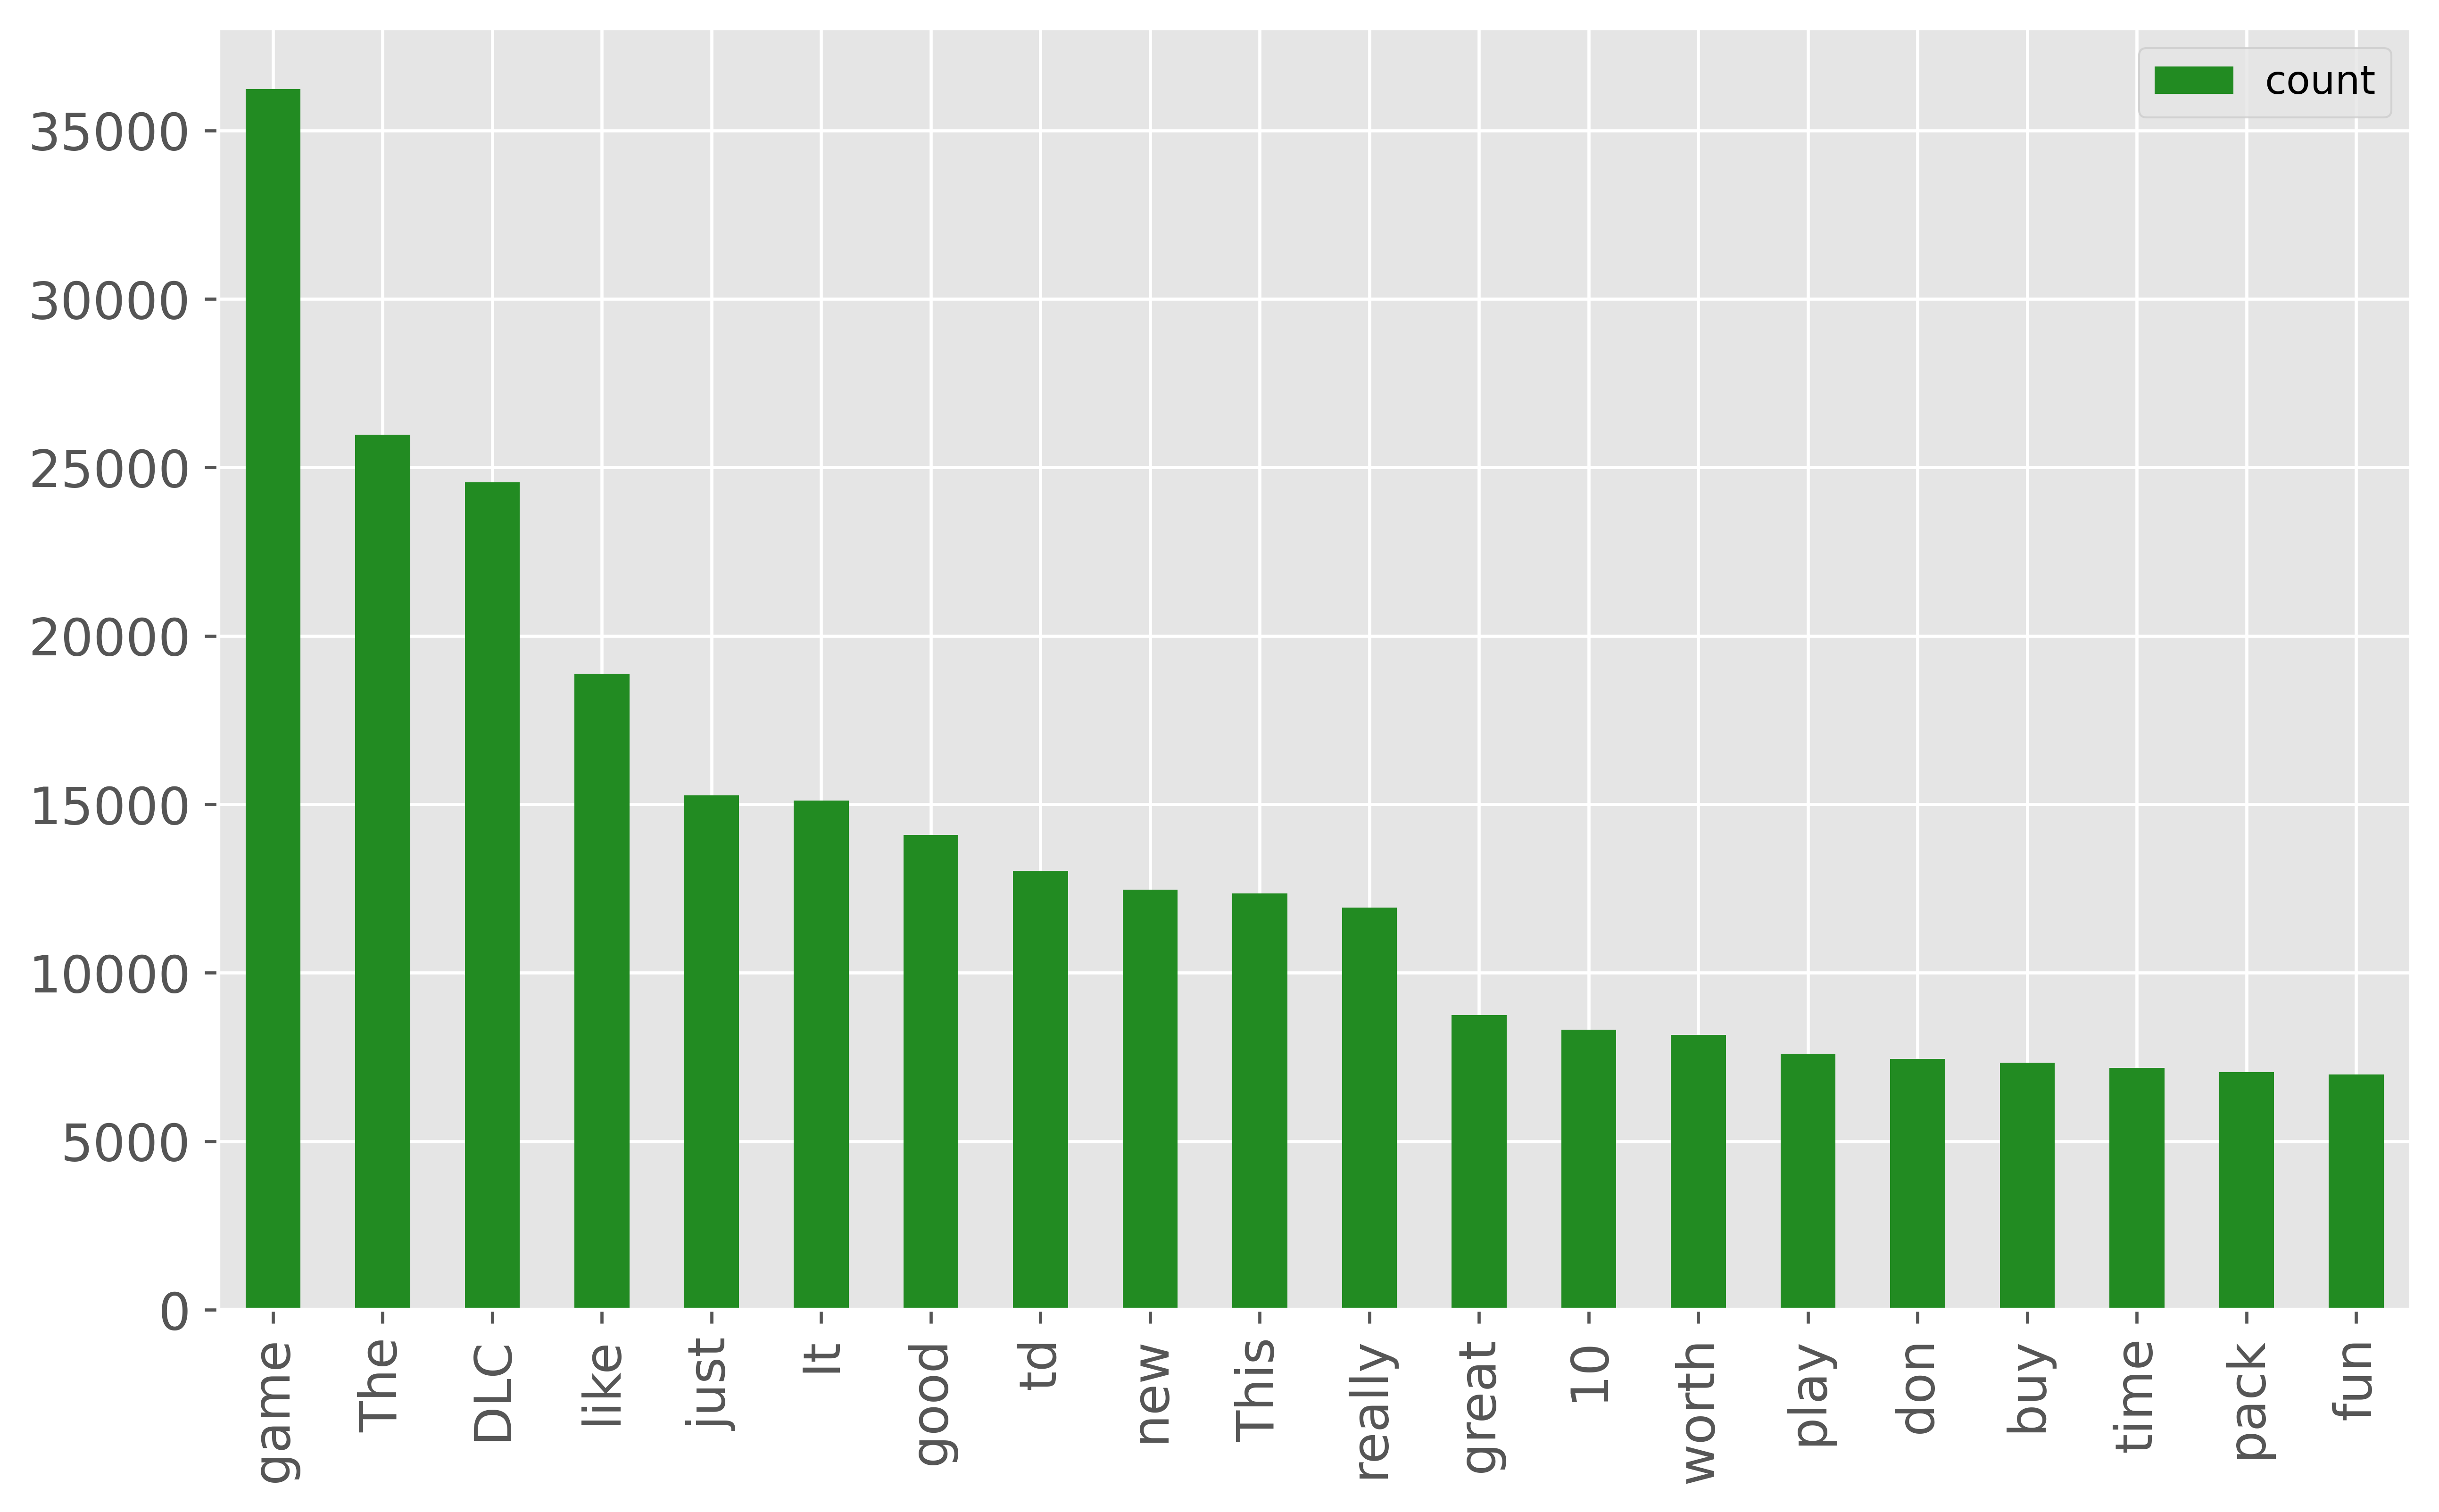

In [8]:
dfplot = pd.DataFrame(freq_words[:20], columns = ['count'])
dfplot.plot(kind='bar', figsize=(10,6), fontsize=13);

In [9]:
tfvec = TfidfVectorizer(stop_words = 'english', lowercase=False, ngram_range=(1, 1)) 
X_tfvec = tfvec.fit_transform(X)
columns = tfvec.get_feature_names()
freq_words = get_freq_words(X_tfvec, columns)
print(len(columns))
freq_words[:20]

97139


game      2466.831248
DLC       1753.833497
good      1620.976537
The       1334.364907
like      1296.906214
10        1232.024593
It        1106.942392
just      1028.545762
This       982.279400
worth      969.491557
great      966.295186
nice       923.087594
really     922.646678
new        902.444401
dlc        834.968044
buy        829.137701
fun        780.233660
pack       755.718968
love       746.827232
play       739.378382
dtype: float64

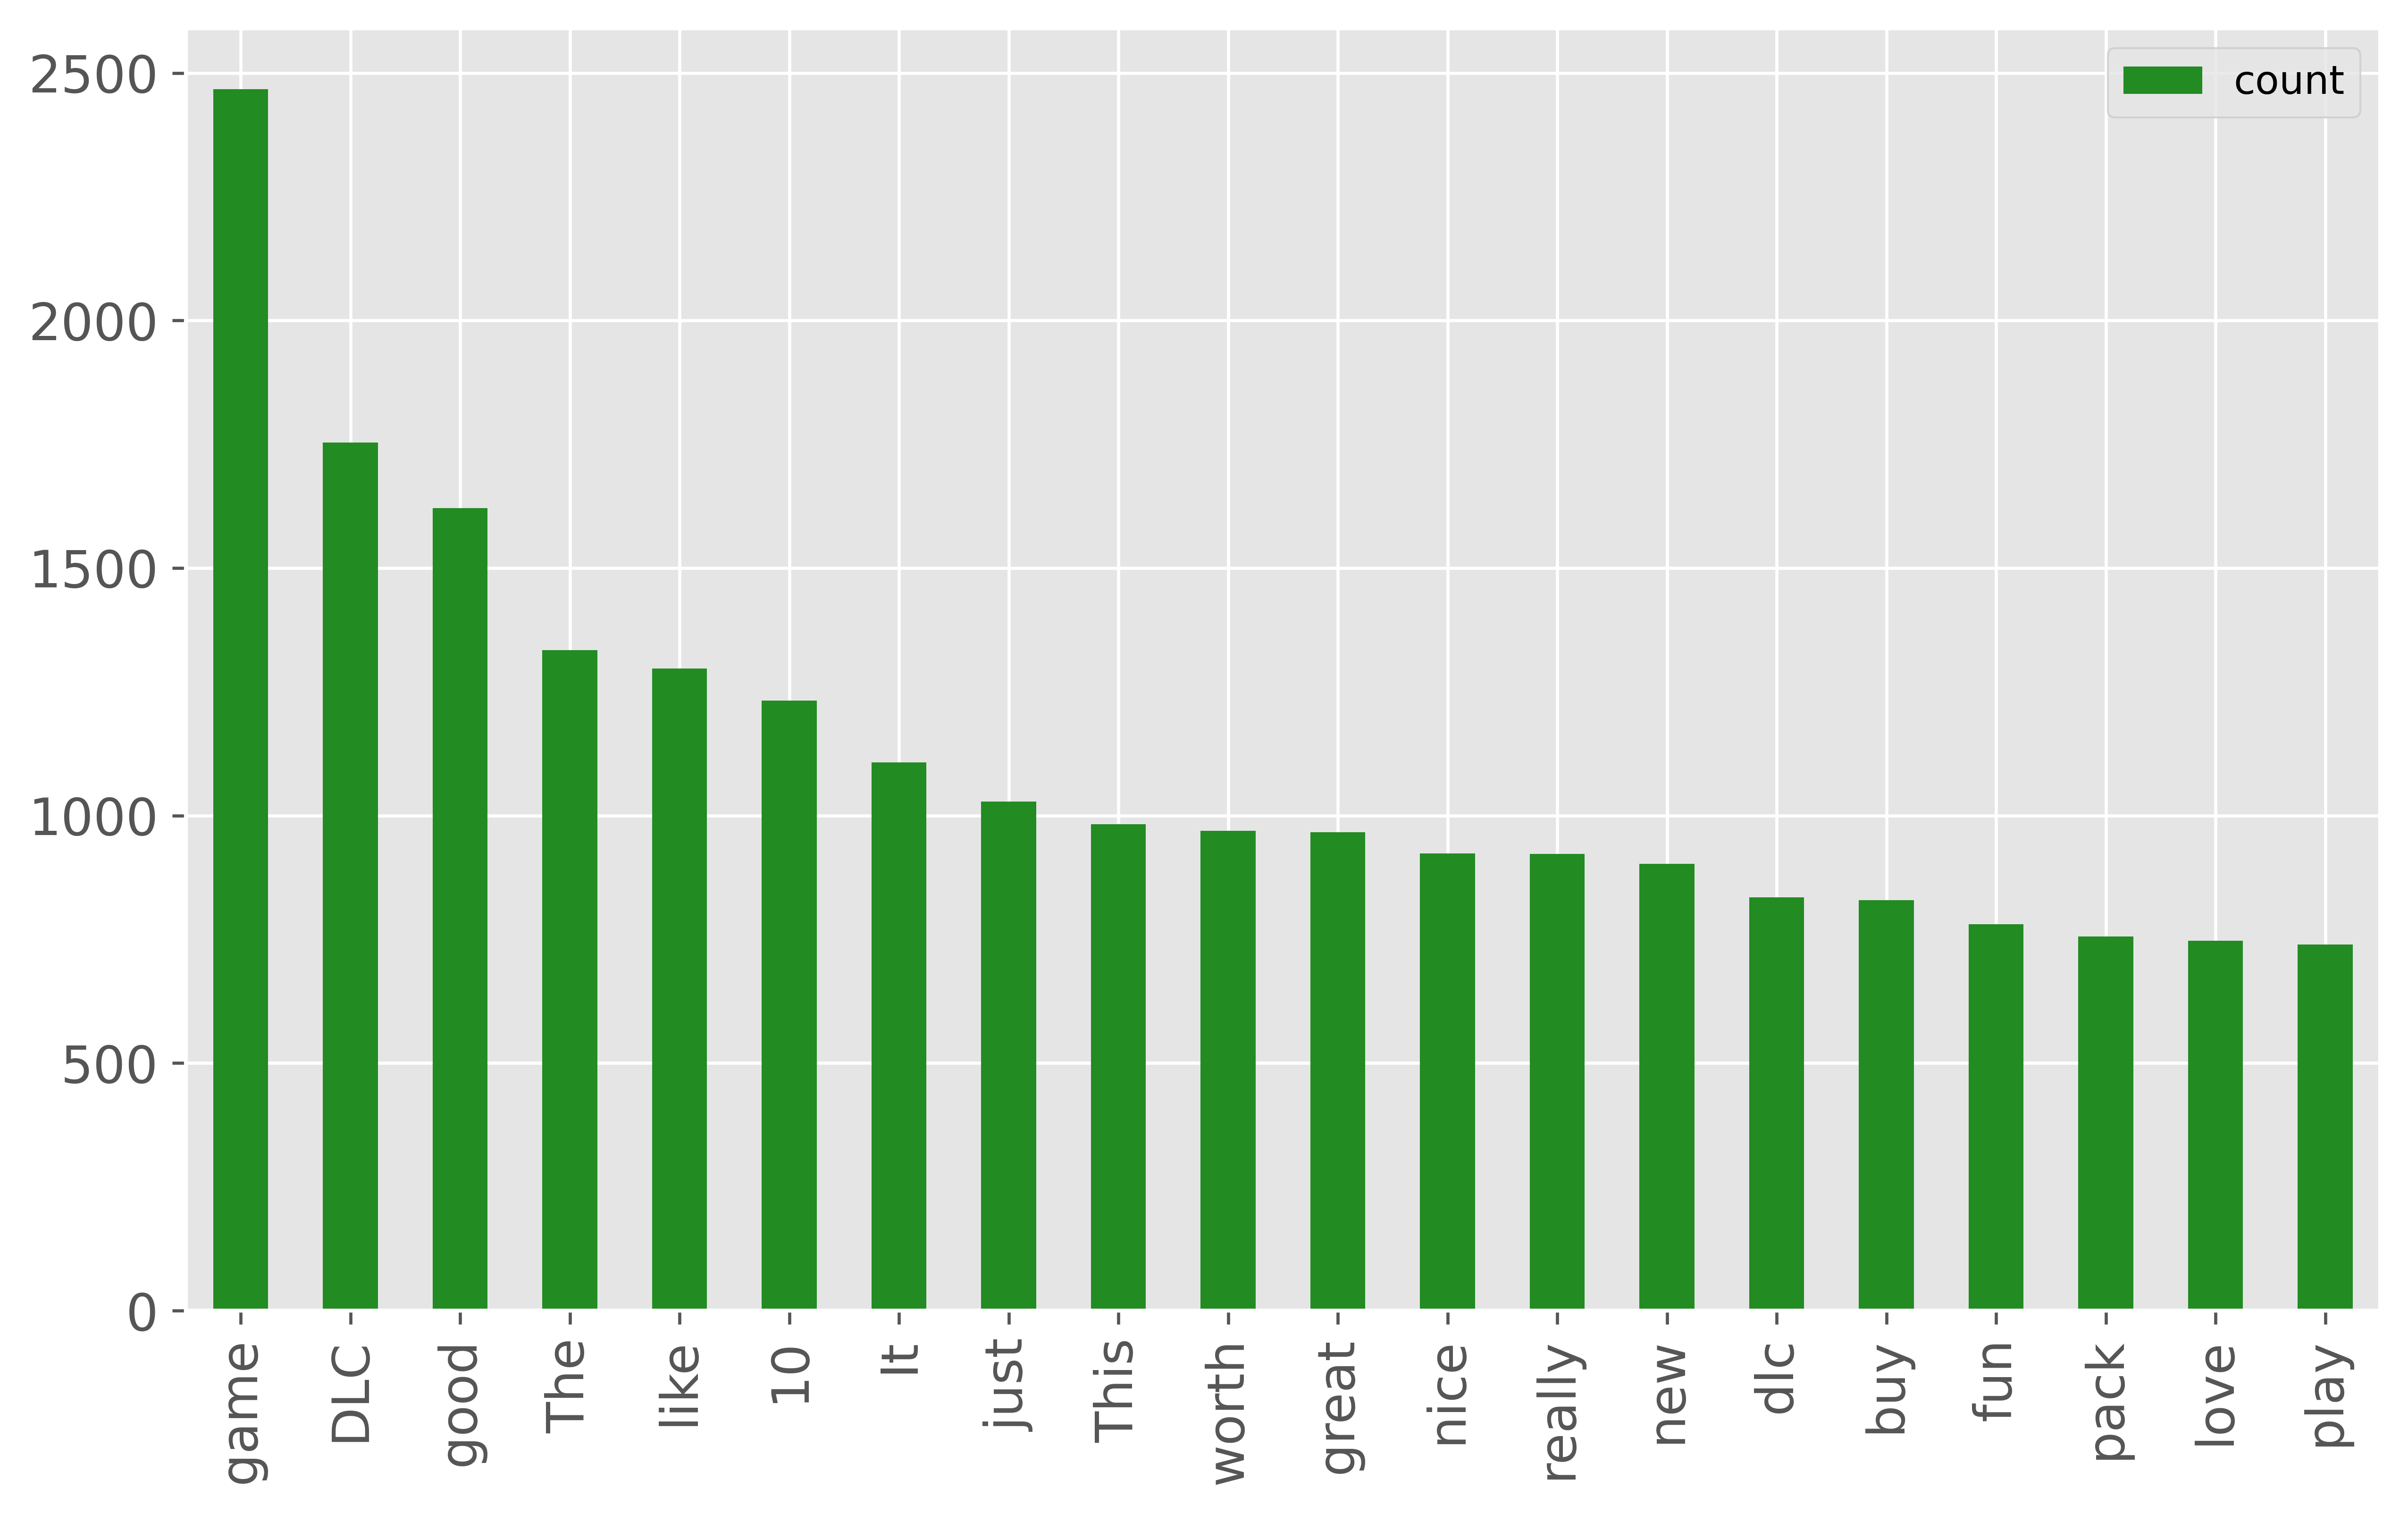

In [10]:
dfplot = pd.DataFrame(freq_words[:20], columns = ['count'])
dfplot.plot(kind='bar', figsize=(10, 6), fontsize=13);

### Without lowercasing

In [11]:
cvec = CountVectorizer(stop_words = 'english', ngram_range=(1, 1)) 
X_cvec = cvec.fit_transform(X)
columns = cvec.get_feature_names()
freq_words = get_freq_words(X_cvec, columns)
print(len(columns))
freq_words[:20]

74556


game      37654
dlc       29695
like      19661
just      17356
good      16299
new       13905
td        13050
really    13000
great     11470
worth      8920
don        8796
buy        8617
pack       8396
10         8312
nice       8000
play       7940
fun        7548
time       7463
want       5980
love       5883
dtype: int64

In [12]:
tfvec = TfidfVectorizer(stop_words = 'english', ngram_range=(1, 1)) 
X_tfvec = tfvec.fit_transform(X)
columns = tfvec.get_feature_names()
freq_words = get_freq_words(X_tfvec, columns)
print(len(columns))
freq_words[:20]

74556


game      2767.342956
dlc       2381.104847
good      2210.411231
great     1492.893678
like      1430.128089
10        1298.285953
nice      1286.825950
just      1258.789067
worth     1197.244808
really    1089.772426
new       1038.647906
buy       1037.649064
love      1015.655619
fun       1008.776186
pack       902.226416
play       824.349729
best       801.437056
don        755.815236
money      725.396550
bought     672.010160
dtype: float64

Upon initial inspection both give quite similar results, TF-IDF seems to be slightly better in the top10

### What are the top words in each class?

In [13]:
tfvec = TfidfVectorizer(stop_words = 'english', ngram_range=(1, 1)) 
X_tfvec = tfvec.fit_transform(df[df.helpful == 'helpful'].review)
columns = tfvec.get_feature_names()
freq_words = get_freq_words(X_tfvec, columns)
print(len(columns))
freq_words[:20]

58910


game      1379.109341
dlc       1196.012027
good       879.162612
like       749.305347
just       687.410491
great      687.198964
new        627.818074
worth      607.992201
really     604.544640
nice       589.368262
10         578.311057
buy        541.063418
pack       498.115589
love       456.577384
fun        445.319344
don        419.959223
play       415.146541
best       406.183168
money      362.962109
price      355.366112
dtype: float64

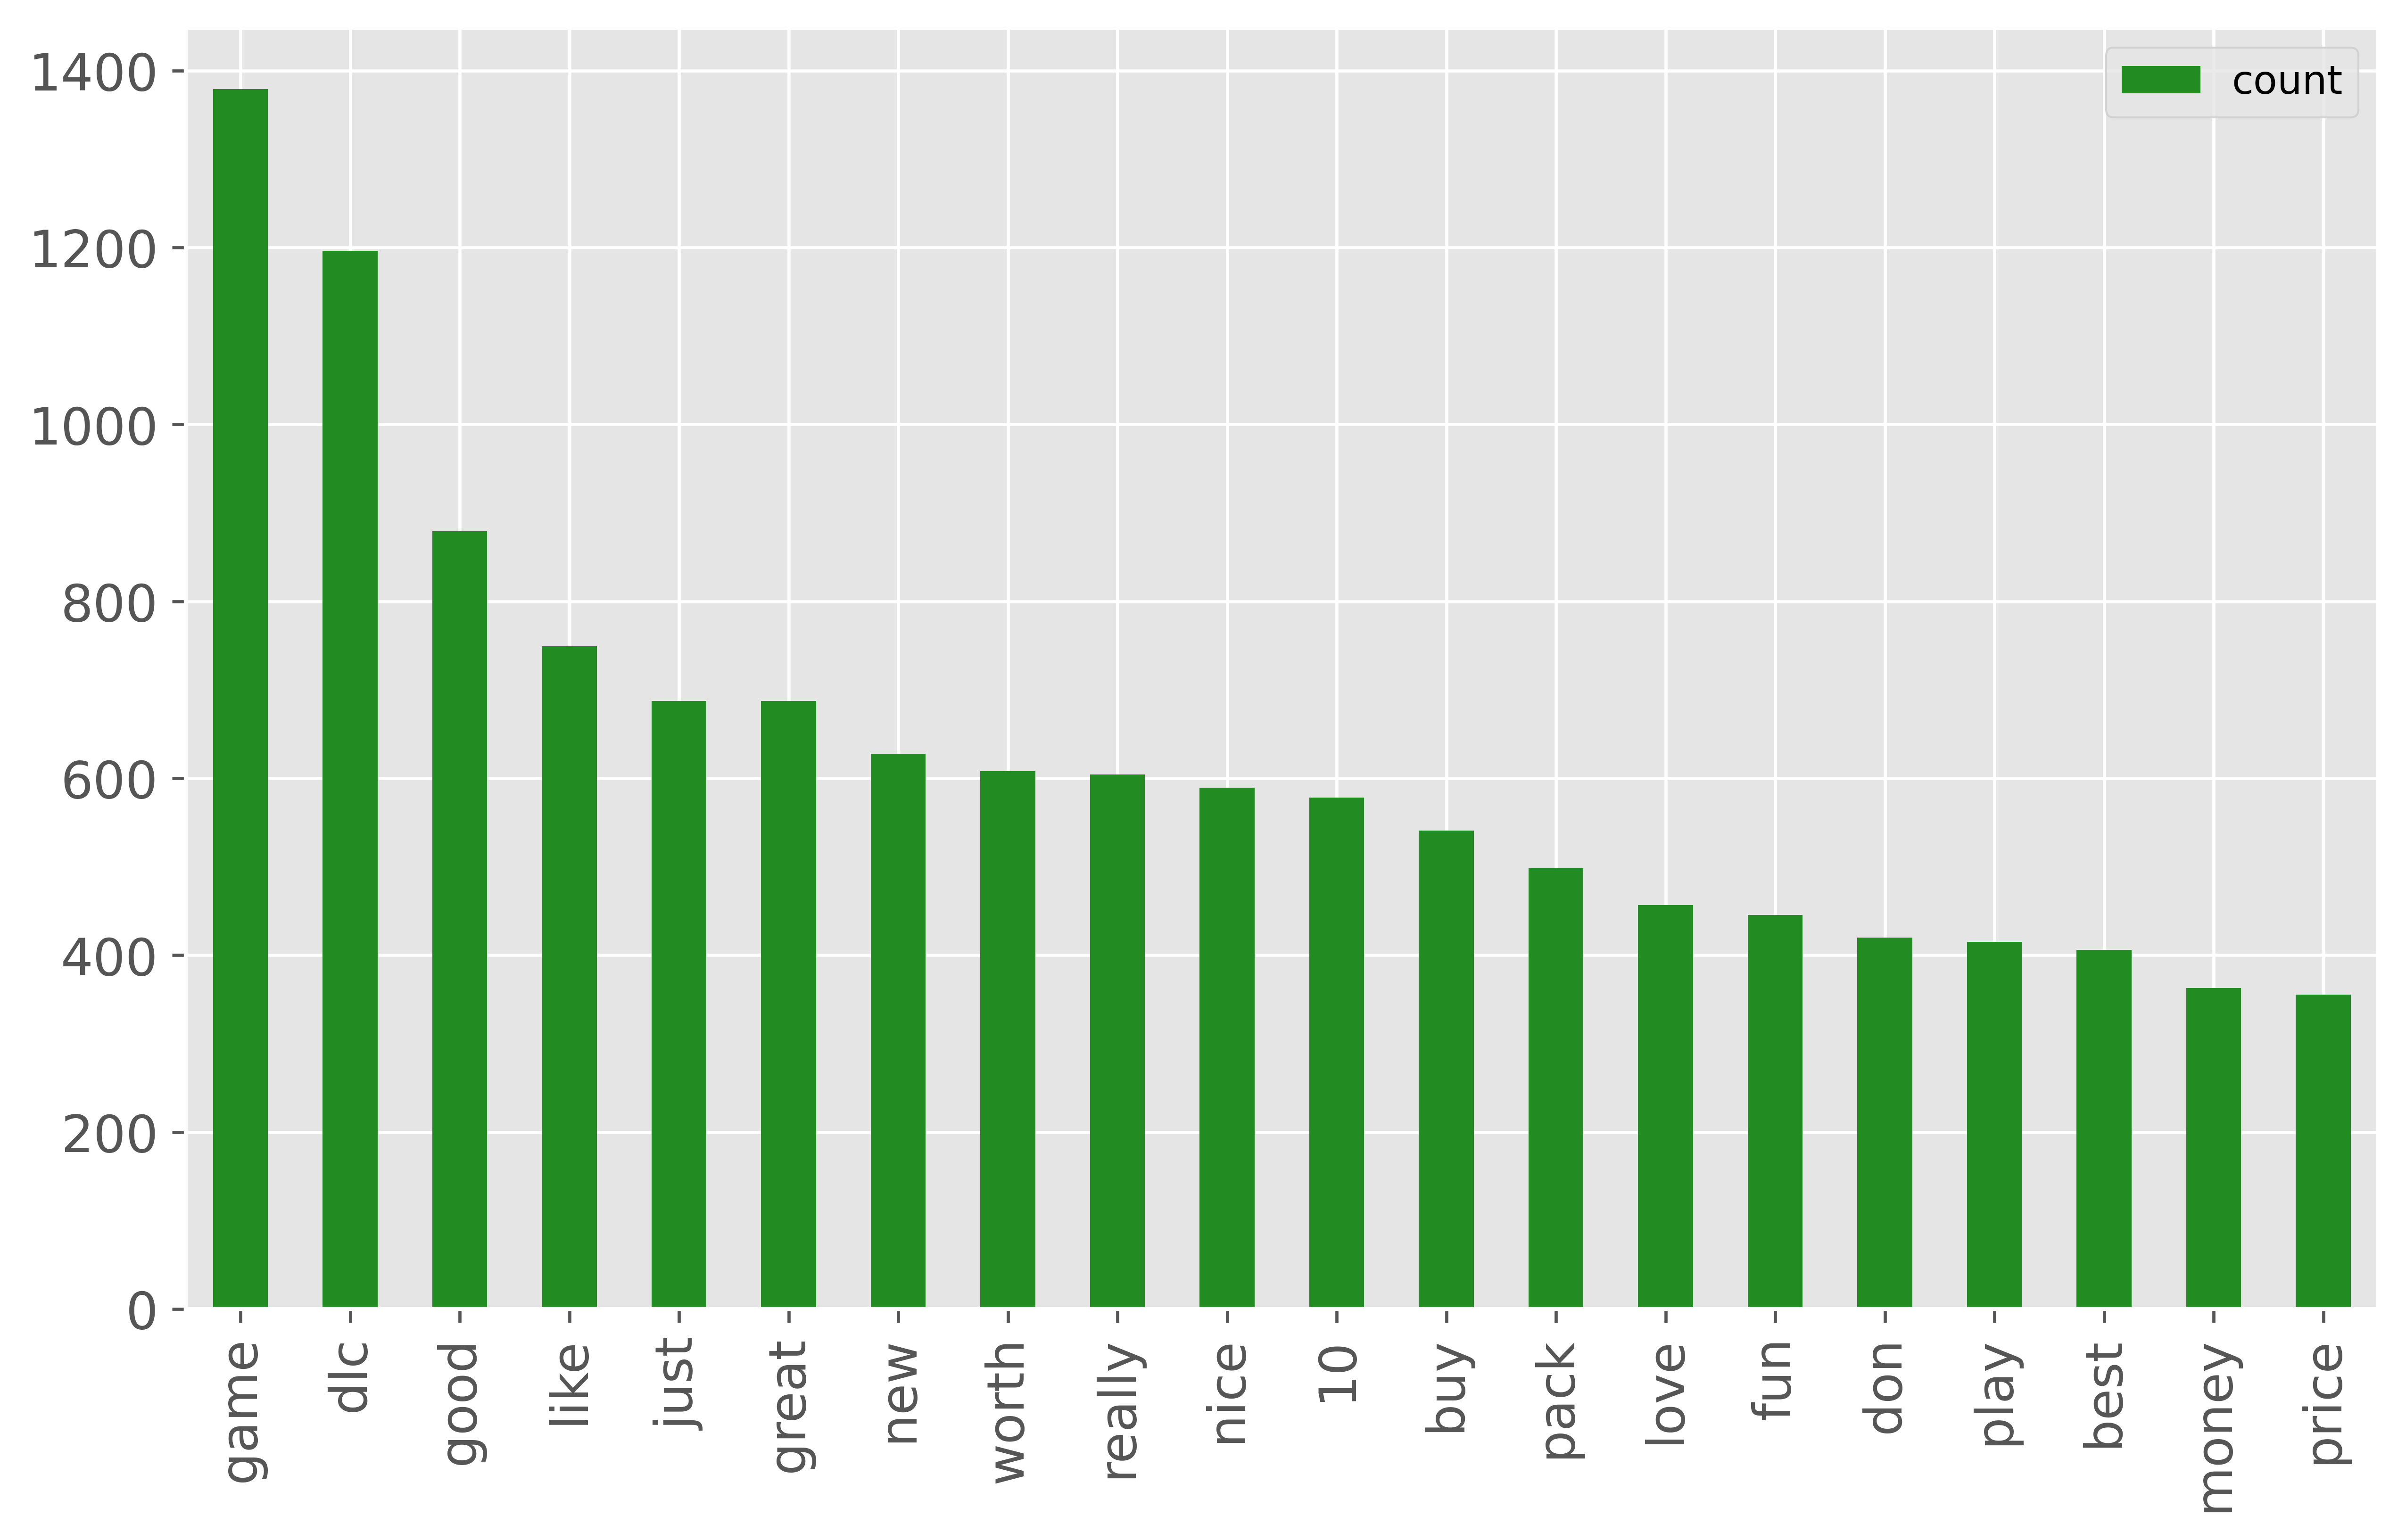

In [14]:
dfplot = pd.DataFrame(freq_words[:20], columns = ['count'])
dfplot.plot(kind='bar', figsize=(10,6), fontsize=13);

In [15]:
tfvec = TfidfVectorizer(stop_words = 'english', ngram_range=(1, 1)) 
X_tfvec = tfvec.fit_transform(df[df.helpful == 'not-helpful'].review)
columns = tfvec.get_feature_names()
freq_words = get_freq_words(X_tfvec, columns)
print(len(columns))
freq_words[:20]

40841


game      1397.070654
good      1332.610057
dlc       1193.863355
great      807.250079
10         725.470098
nice       699.690801
like       686.054692
worth      591.448123
just       575.573874
fun        564.873539
love       561.337163
buy        501.375856
really     487.572853
play       414.112074
new        409.930561
pack       408.192932
best       398.545049
money      365.582232
cool       358.396788
bought     340.043804
dtype: float64

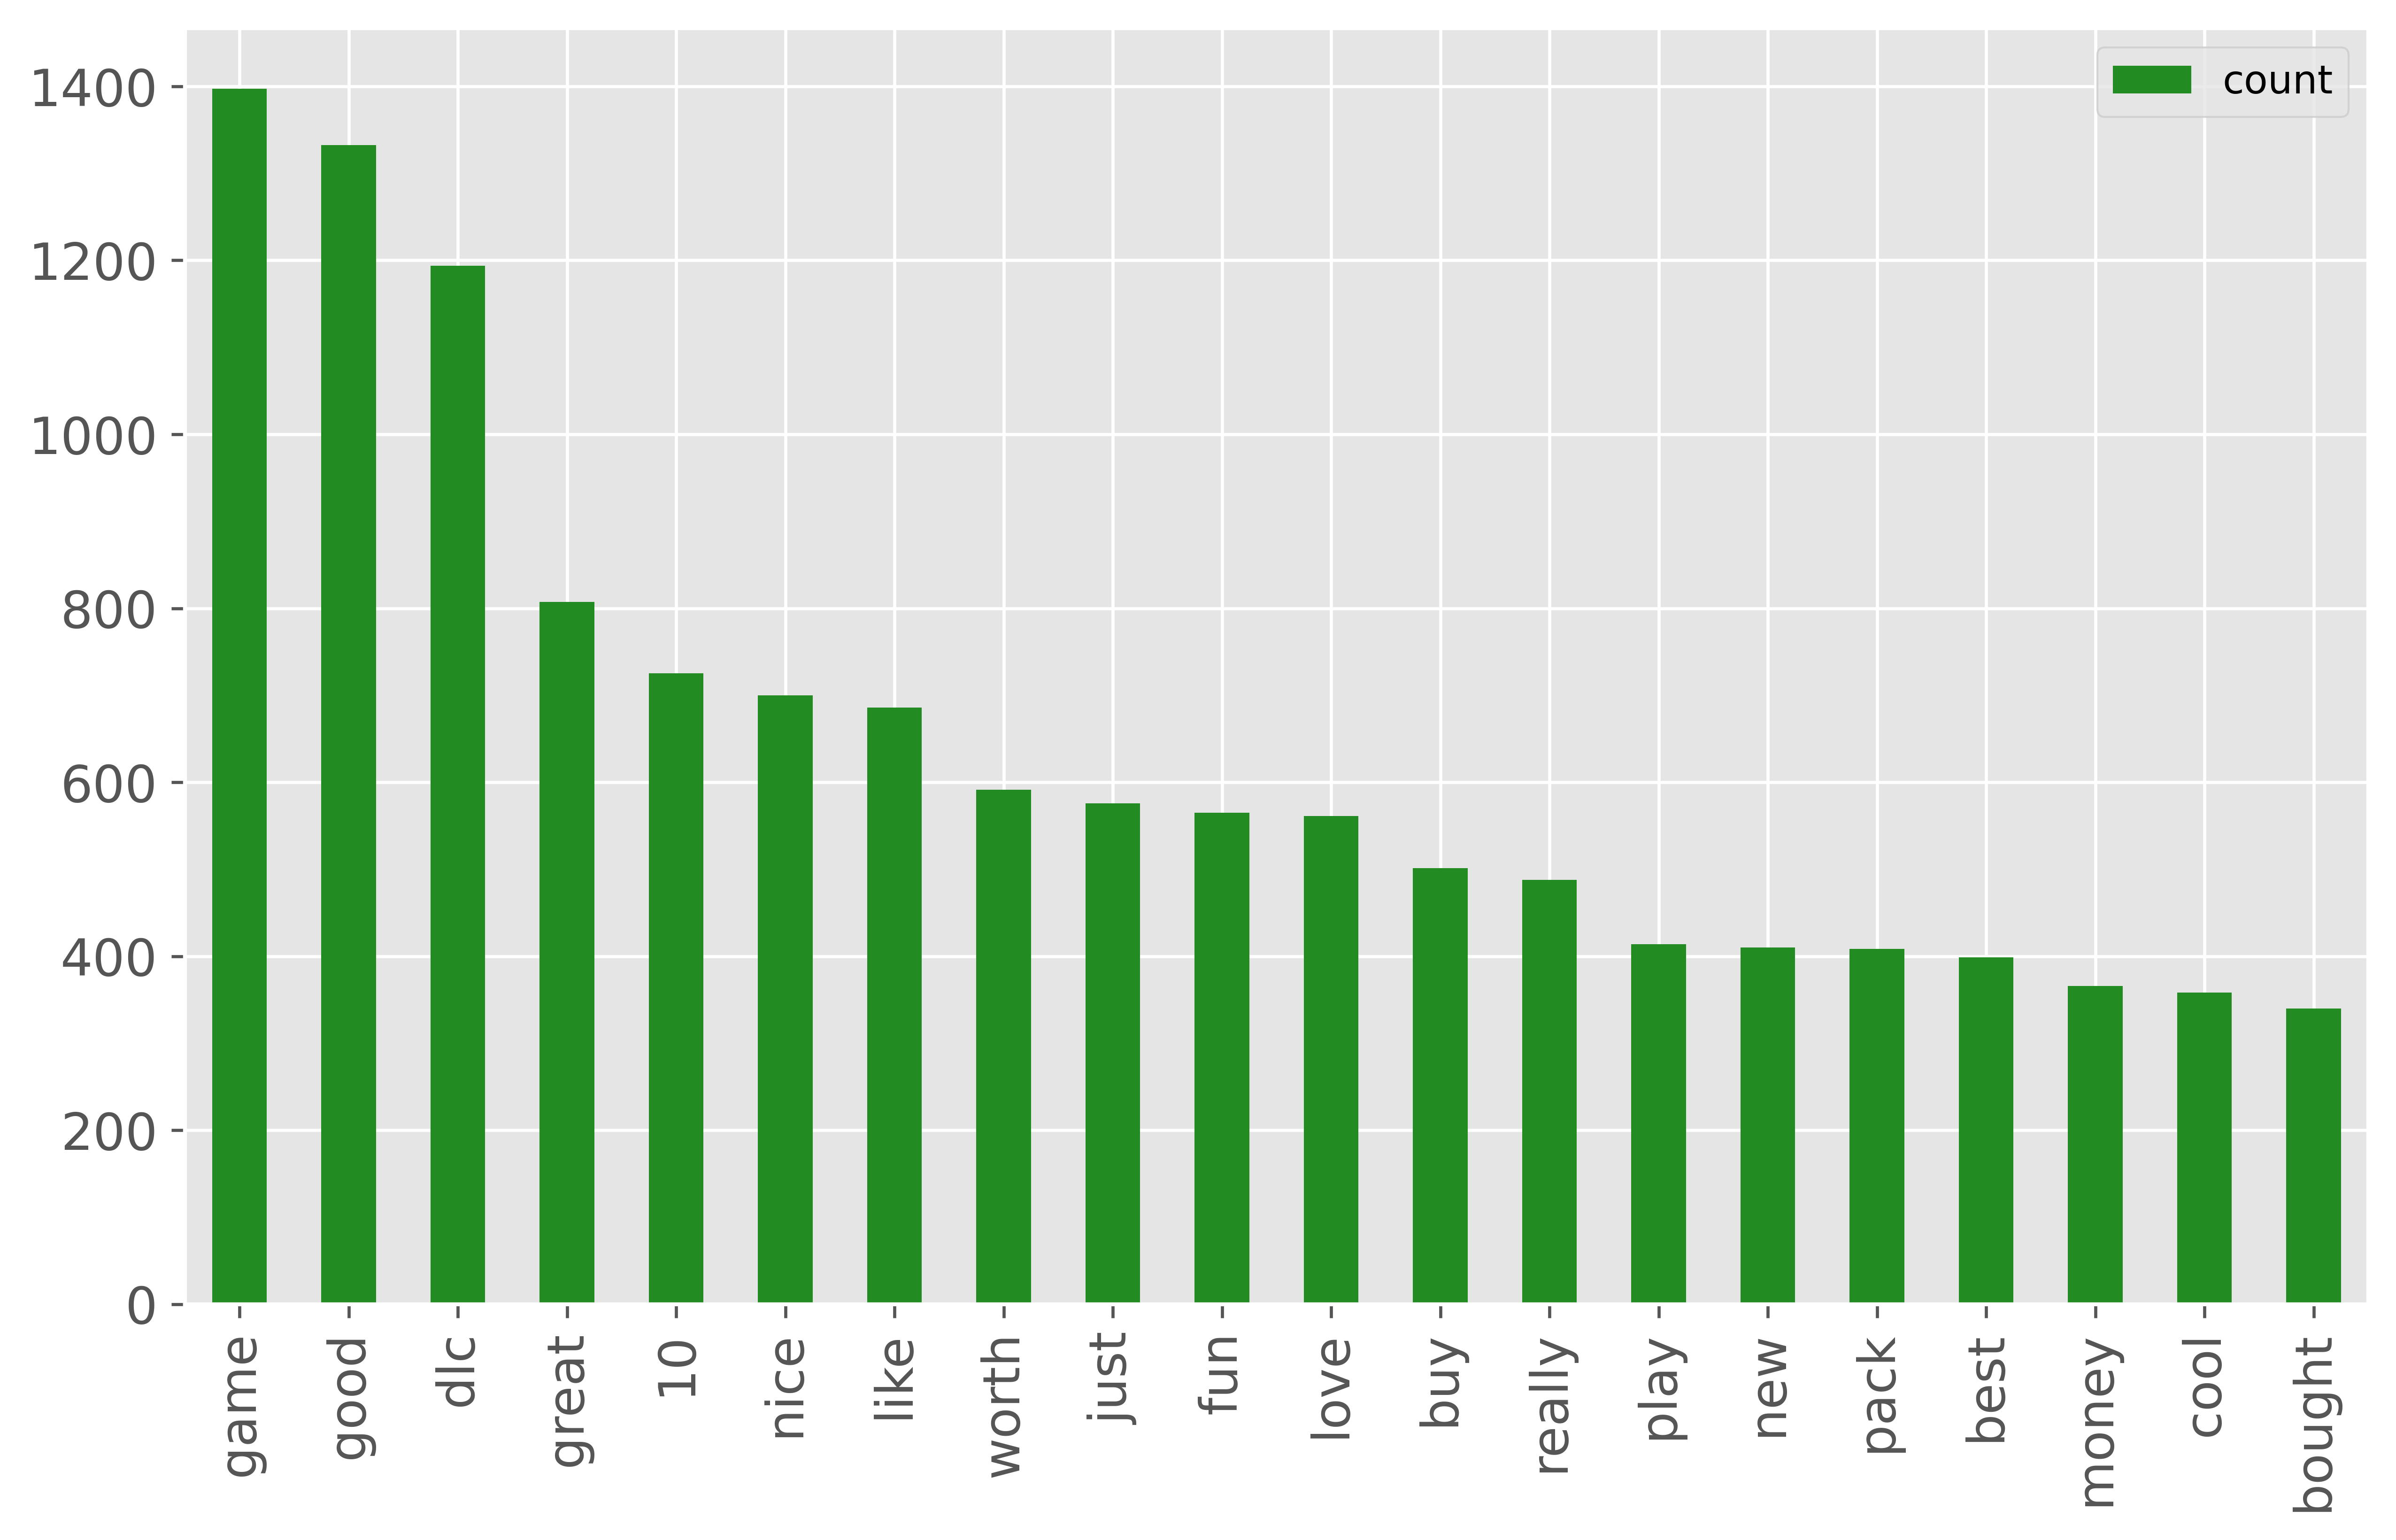

In [16]:
dfplot = pd.DataFrame(freq_words[:20], columns = ['count'])
dfplot.plot(kind='bar', figsize=(10,6), fontsize=13);

# CountVectorizer vs TFIDF Baseline model comparison

Comparing performance of CountVectorizer and TF-IDF Vectorizer against multiple baseline models to determine which model to tune in the next step.

In [17]:
df.helpful.value_counts(normalize=True) #checking baseline

helpful        0.505155
not-helpful    0.494845
Name: helpful, dtype: float64

In [18]:
X = df.review
y = df.helpful

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, stratify = y, random_state=100)
#setting random state to ensure fair comparison 

In [19]:
cvec = CountVectorizer(lowercase=False, max_df = 0.8, ngram_range=(1, 1)) 
#capitalisation etc could be important, can change ngrams later

X_train = cvec.fit_transform(X_train)
X_test = cvec.transform(X_test)

In [20]:
def benchmark(clf):
    print(('_' * 80))
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(("train time: %0.3fs" % train_time))

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(("test time:  %0.3fs" % test_time))

    score = metrics.accuracy_score(y_test, pred)
    print(("accuracy:   %0.3f" % score))

    if hasattr(clf, 'coef_'):
        print(("dimensionality: %d" % clf.coef_.shape[1]))
        print(("density: %f" % density(clf.coef_)))
        print()

    print("classification report:")
    print((metrics.classification_report(y_test, pred)))

    print("confusion matrix:")
    print((metrics.confusion_matrix(y_test, pred)))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (LogisticRegression(max_iter = 1000, n_jobs = -2), 'Logistic Regression'),
        (RidgeClassifier(max_iter = 1000, tol=1e-2), "Ridge Classifier"),
        (Perceptron(max_iter=1000, tol=1e-3, n_jobs=-2), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, n_jobs= -2), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10, n_jobs=-2), "kNN"),
        (RandomForestClassifier(n_estimators=100, n_jobs = -2), "Random forest")):
    print(('=' * 80))
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print(('=' * 80))
    print(("%s penalty" % penalty.upper()))
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='squared_hinge', penalty=penalty,
                                            dual=False)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001,
                                           penalty=penalty,
                                           max_iter=1000,
                                           tol=1e-3, n_jobs=-2)))

# Train SGD with Elastic Net penalty
print(('=' * 80))
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001,
                                       penalty="elasticnet",
                                       max_iter=1000,
                                       tol=1e-3, n_jobs=-2)))

# Train NearestCentroid without threshold
print(('=' * 80))
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print(('=' * 80))
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print(('=' * 80))
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False ))),
    ('classification', LinearSVC(penalty="l2"))])))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(max_iter=1000, n_jobs=-2)
train time: 15.043s
test time:  0.001s
accuracy:   0.655
dimensionality: 96421
density: 1.000000

classification report:
              precision    recall  f1-score   support

     helpful       0.69      0.57      0.62       773
 not-helpful       0.63      0.74      0.68       758

    accuracy                           0.66      1531
   macro avg       0.66      0.66      0.65      1531
weighted avg       0.66      0.66      0.65      1531

confusion matrix:
[[439 334]
 [194 564]]

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(max_iter=1000, tol=0.01)
train time: 9.536s
test time:  0.001s
accuracy:   0.638
dimensionality: 96421
density: 1.000000

classification report:
              precision    recall  f1-score   support

     helpful       0.69     

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


train time: 101.927s
test time:  0.002s
accuracy:   0.658
dimensionality: 96421
density: 1.000000

classification report:
              precision    recall  f1-score   support

     helpful       0.69      0.58      0.63       773
 not-helpful       0.63      0.74      0.68       758

    accuracy                           0.66      1531
   macro avg       0.66      0.66      0.66      1531
weighted avg       0.66      0.66      0.66      1531

confusion matrix:
[[450 323]
 [200 558]]

________________________________________________________________________________
Training: 
SGDClassifier(n_jobs=-2)
train time: 1.040s
test time:  0.000s
accuracy:   0.639
dimensionality: 96421
density: 0.958163

classification report:
              precision    recall  f1-score   support

     helpful       0.71      0.47      0.57       773
 not-helpful       0.60      0.81      0.69       758

    accuracy                           0.64      1531
   macro avg       0.66      0.64      0.63      1531


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


train time: 25.039s
test time:  0.000s
accuracy:   0.660
dimensionality: 96421
density: 0.314008

classification report:
              precision    recall  f1-score   support

     helpful       0.70      0.57      0.63       773
 not-helpful       0.63      0.75      0.69       758

    accuracy                           0.66      1531
   macro avg       0.67      0.66      0.66      1531
weighted avg       0.67      0.66      0.66      1531

confusion matrix:
[[443 330]
 [191 567]]

________________________________________________________________________________
Training: 
SGDClassifier(n_jobs=-2, penalty='l1')
train time: 4.261s
test time:  0.000s
accuracy:   0.609
dimensionality: 96421
density: 0.022080

classification report:
              precision    recall  f1-score   support

     helpful       0.71      0.38      0.50       773
 not-helpful       0.57      0.84      0.68       758

    accuracy                           0.61      1531
   macro avg       0.64      0.61      0.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 0.192s
test time:  0.003s
accuracy:   0.630
dimensionality: 96421
density: 1.000000

classification report:
              precision    recall  f1-score   support

     helpful       0.71      0.45      0.55       773
 not-helpful       0.59      0.81      0.68       758

    accuracy                           0.63      1531
   macro avg       0.65      0.63      0.62      1531
weighted avg       0.65      0.63      0.62      1531

confusion matrix:
[[349 424]
 [143 615]]

LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', LinearSVC())])


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


train time: 43.648s
test time:  0.002s
accuracy:   0.660
classification report:
              precision    recall  f1-score   support

     helpful       0.70      0.58      0.63       773
 not-helpful       0.63      0.74      0.68       758

    accuracy                           0.66      1531
   macro avg       0.66      0.66      0.66      1531
weighted avg       0.66      0.66      0.66      1531

confusion matrix:
[[448 325]
 [196 562]]



/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


### Plotting results

In [21]:
model_names = ['LogisticRegression',
  'RidgeClassifier',
  'Perceptron',
  'PassiveAggressiveClassifier',
  'KNeighborsClassifier',
  'RandomForestClassifier',
  'LinearSVC_L2',
  'SGDClassifier_L2',
  'LinearSVC_L1',
  'SGDClassifier_L1',
  'SGDClassifier_ENet',
  'NearestCentroid',
  'MultinomialNB',
  'BernoulliNB',
  'LinearSVC_L1FeatureSel']

In [22]:
indices = np.arange(len(results))
results = [[x[i] for x in results] for i in range(4)]

In [23]:
joblib.dump(results, 'data/CVECbaseline_model_results')

['data/CVECbaseline_model_results']

In [24]:
rdf = pd.DataFrame(data = results).T
rdf.columns = ['Model', 'Score', 'Training_time', 'Test_time']
rdf.Model = model_names
rdf.Training_time = np.array(rdf.Training_time)/np.max(rdf.Training_time)
rdf.Test_time = np.array(rdf.Test_time)/np.max(rdf.Test_time)
rdf.sort_values(by='Score', ascending=True, inplace=True)
rdf.reset_index(drop=True, inplace=True)

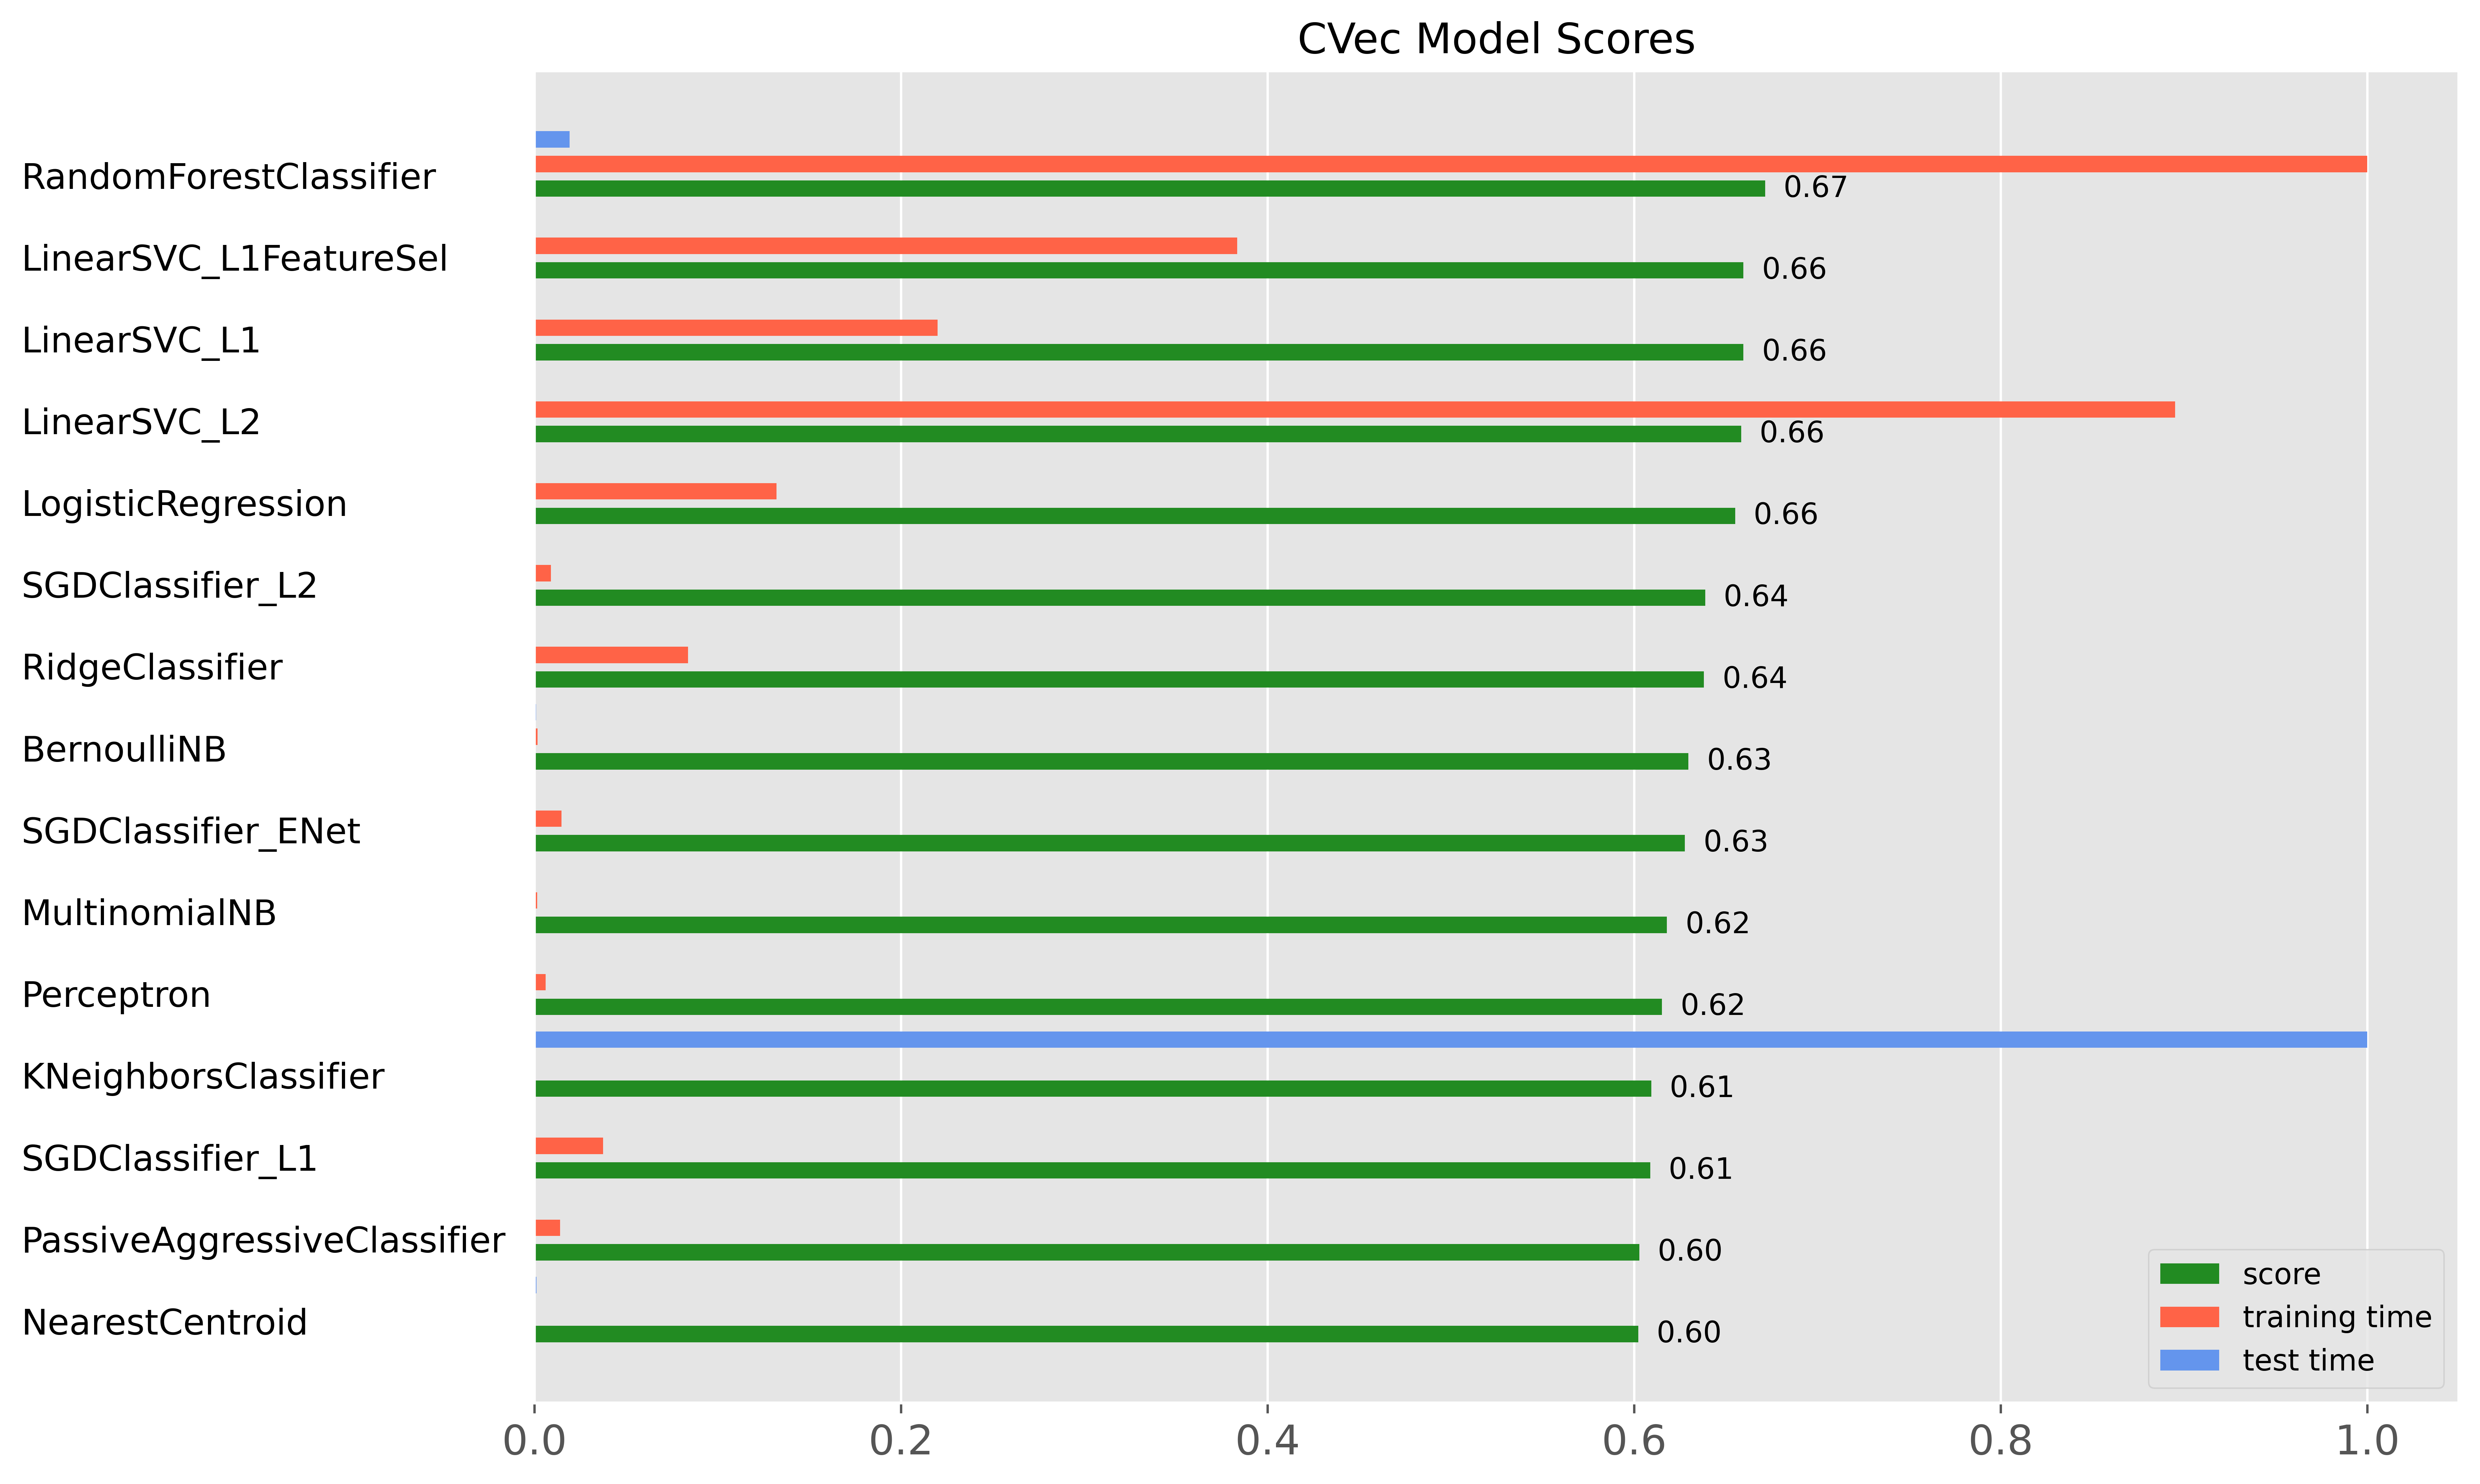

In [25]:
plt.figure(figsize=(14, 7))
plt.title("CVec Model Scores")
plt.barh(indices, rdf.Score, .2, label="score")
plt.barh(indices + .3, rdf.Training_time, .2, label="training time")
plt.barh(indices + .6, rdf.Test_time, .2, label="test time")
plt.yticks((), fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, rdf.Model):
    plt.text(-.28, i, c, fontsize=12)
    
for i, value in enumerate(rdf.Score):
    plt.text(value + 0.01, i -0.1, str(("%.2f" %value)), fontsize=10)

plt.savefig("cvec_baseline_models.png")
    
plt.show()

## TF-IDF Vectorizer

In [26]:
X = df.review
y = df.helpful

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.02, stratify = y, random_state=100)
#setting random state to ensure fair comparison 

tfvec = TfidfVectorizer(lowercase=False, max_df = 0.8, ngram_range=(1, 1)) 
#capitalisation etc could be important, can change ngrams later

X_train = tfvec.fit_transform(X_train)
X_test = tfvec.transform(X_test)

In [27]:
# Benchmark classifiers

def benchmark(clf):
    print(('_' * 80))
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(("train time: %0.3fs" % train_time))

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(("test time:  %0.3fs" % test_time))

    score = metrics.accuracy_score(y_test, pred)
    print(("accuracy:   %0.3f" % score))

    if hasattr(clf, 'coef_'):
        print(("dimensionality: %d" % clf.coef_.shape[1]))
        print(("density: %f" % density(clf.coef_)))
        print()

    print("classification report:")
    print((metrics.classification_report(y_test, pred)))

    print("confusion matrix:")
    print((metrics.confusion_matrix(y_test, pred)))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (LogisticRegression(max_iter = 1000, n_jobs = -2), 'Logistic Regression'),
        (RidgeClassifier(max_iter = 1000, tol=1e-2), "Ridge Classifier"),
        (Perceptron(max_iter=1000, tol=1e-3, n_jobs=-2), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=1000, tol=1e-3, n_jobs= -2), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10, n_jobs=-2), "kNN"),
        (RandomForestClassifier(n_estimators=100, n_jobs = -2), "Random forest")):
    print(('=' * 80))
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print(('=' * 80))
    print(("%s penalty" % penalty.upper()))
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='squared_hinge', penalty=penalty,
                                            dual=False)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001,
                                           penalty=penalty,
                                           max_iter=1000,
                                           tol=1e-3, n_jobs=-2)))

# Train SGD with Elastic Net penalty
print(('=' * 80))
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001,
                                       penalty="elasticnet",
                                       max_iter=1000,
                                       tol=1e-3, n_jobs=-2)))

# Train NearestCentroid without threshold
print(('=' * 80))
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print(('=' * 80))
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print(('=' * 80))
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
    ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False ))),
    ('classification', LinearSVC(penalty="l2"))])))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(max_iter=1000, n_jobs=-2)
train time: 3.282s
test time:  0.001s
accuracy:   0.665
dimensionality: 96421
density: 1.000000

classification report:
              precision    recall  f1-score   support

     helpful       0.67      0.66      0.67       773
 not-helpful       0.66      0.67      0.66       758

    accuracy                           0.66      1531
   macro avg       0.66      0.66      0.66      1531
weighted avg       0.67      0.66      0.66      1531

confusion matrix:
[[510 263]
 [250 508]]

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(max_iter=1000, tol=0.01)
train time: 0.660s
test time:  0.001s
accuracy:   0.662
dimensionality: 96421
density: 1.000000

classification report:
              precision    recall  f1-score   support

     helpful       0.67      

train time: 0.212s
test time:  0.001s
accuracy:   0.654
dimensionality: 96421
density: 1.000000

classification report:
              precision    recall  f1-score   support

     helpful       0.65      0.69      0.67       773
 not-helpful       0.66      0.62      0.64       758

    accuracy                           0.65      1531
   macro avg       0.65      0.65      0.65      1531
weighted avg       0.65      0.65      0.65      1531

confusion matrix:
[[531 242]
 [288 470]]

________________________________________________________________________________
Training: 
BernoulliNB(alpha=0.01)


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 0.234s
test time:  0.004s
accuracy:   0.630
dimensionality: 96421
density: 1.000000

classification report:
              precision    recall  f1-score   support

     helpful       0.71      0.45      0.55       773
 not-helpful       0.59      0.81      0.68       758

    accuracy                           0.63      1531
   macro avg       0.65      0.63      0.62      1531
weighted avg       0.65      0.63      0.62      1531

confusion matrix:
[[349 424]
 [143 615]]

LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False,
                                                     penalty='l1'))),
                ('classification', LinearSVC())])


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 3.159s
test time:  0.002s
accuracy:   0.658
classification report:
              precision    recall  f1-score   support

     helpful       0.67      0.63      0.65       773
 not-helpful       0.65      0.68      0.66       758

    accuracy                           0.66      1531
   macro avg       0.66      0.66      0.66      1531
weighted avg       0.66      0.66      0.66      1531

confusion matrix:
[[489 284]
 [240 518]]



### Plotting results

In [28]:
model_names = ['LogisticRegression',
  'RidgeClassifier',
  'Perceptron',
  'PassiveAggressiveClassifier',
  'KNeighborsClassifier',
  'RandomForestClassifier',
  'LinearSVC_L2',
  'SGDClassifier_L2',
  'LinearSVC_L1',
  'SGDClassifier_L1',
  'SGDClassifier_ENet',
  'NearestCentroid',
  'MultinomialNB',
  'BernoulliNB',
  'LinearSVC_L1FeatureSel']

In [29]:
indices = np.arange(len(results))
results = [[x[i] for x in results] for i in range(4)]

In [30]:
joblib.dump(results, 'data/TFIDFbaseline_model_results')

['data/TFIDFbaseline_model_results']

In [31]:
rdf = pd.DataFrame(data = results).T
rdf.columns = ['Model', 'Score', 'Training_time', 'Test_time']
rdf.Model = model_names
rdf.Training_time = np.array(rdf.Training_time)/np.max(rdf.Training_time)
rdf.Test_time = np.array(rdf.Test_time)/np.max(rdf.Test_time)
rdf.sort_values(by='Score', ascending=True, inplace=True)
rdf.reset_index(drop=True, inplace=True)

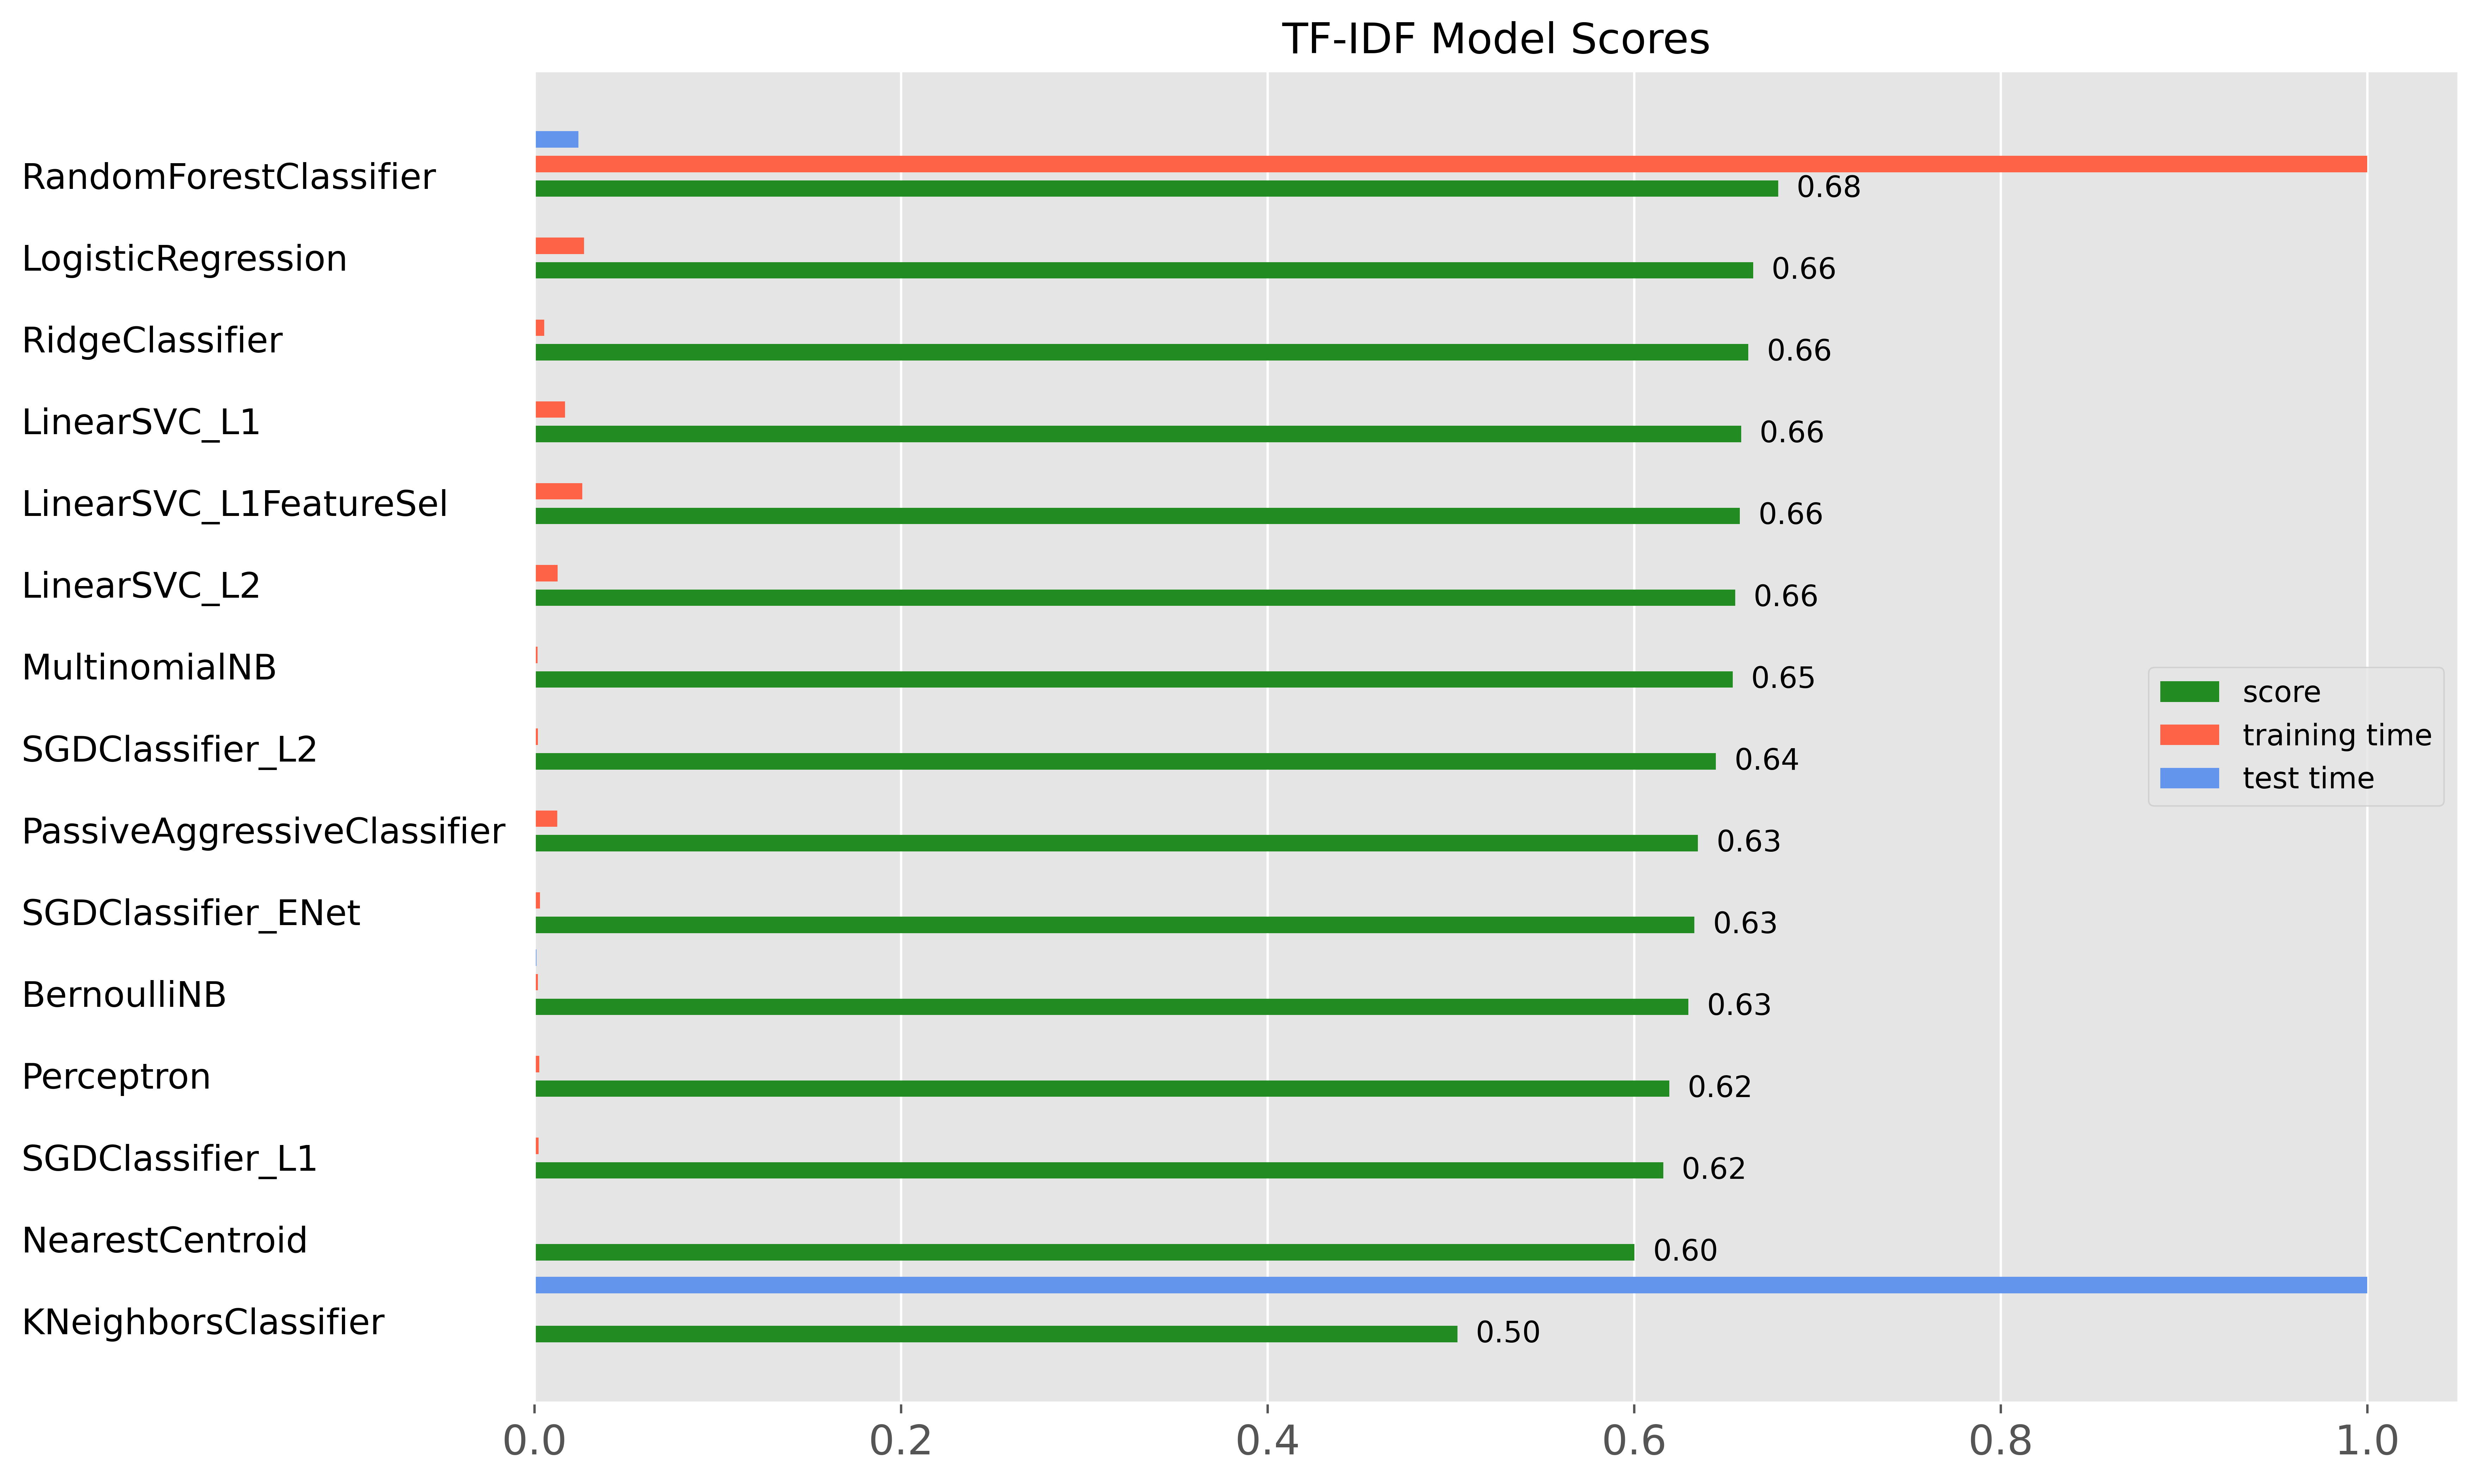

In [32]:
plt.figure(figsize=(14, 7))
plt.title("TF-IDF Model Scores")
plt.barh(indices, rdf.Score, .2, label="score")
plt.barh(indices + .3, rdf.Training_time, .2, label="training time")
plt.barh(indices + .6, rdf.Test_time, .2, label="test time")
plt.yticks((), fontsize=14)
plt.xticks(fontsize=14)
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, rdf.Model):
    plt.text(-.28, i, c, fontsize=12)
    
for i, value in enumerate(rdf.Score):
    plt.text(value + 0.01, i -0.1, str(("%.2f" %value)), fontsize=10)

plt.savefig("tfidf_baseline_models.png")
    
plt.show()

Decided to go with TF-IDF Vectorizer with Logistic Regression and Ridge Classifier models for tuning after comparing score and timings.